In [4]:
# ============================================================
# 🧩 ШАГ 0 — Инициализация дипломного проекта
# ============================================================
# Цель:
# 1) Создаем структуру папок проекта
# 2) Очистим результаты прошлых запусков (чтобы можно было перезапускать ноутбук)
# 3) НЕ удаляем вручную загруженные датасеты (data/raw)


import shutil
from pathlib import Path
from datetime import datetime

# --- Название проекта ---
PROJECT_NAME = "HR_Attendance_Analytics — Аналитика посещаемости сотрудников (FEML)"
NOTEBOOK_NAME = "Employee_Absence_Prediction_Final.ipynb"

# --- Корневая папка проекта внутри Colab ---
ROOT_DIR = Path("./hr_attendance_feml_diploma")

# --- Структура папок ---
DATA_RAW = ROOT_DIR / "data" / "raw"               # сюда вручную положим employees.csv / attendance.csv
DATA_INTERIM = ROOT_DIR / "data" / "interim"       # сюда пишем очищенные/объединенные данные
DATA_PROCESSED = ROOT_DIR / "data" / "processed"   # сюда пишем фичи для моделирования
REPORTS_DIR = ROOT_DIR / "reports"
FIGURES_DIR = REPORTS_DIR / "figures"
MODELS_DIR = ROOT_DIR / "models"


ALL_DIRS = [
    DATA_RAW, DATA_INTERIM, DATA_PROCESSED,
    REPORTS_DIR, FIGURES_DIR, MODELS_DIR, NOTEBOOKS_DIR
]

# --- Что все можно безопасно чистим при каждом перезапуске ---
# raw НЕ трогаем (там исходные CSV)
SAFE_TO_CLEAR = [DATA_INTERIM, DATA_PROCESSED, FIGURES_DIR, MODELS_DIR]

# --- 1) Создаем папки ---
for d in ALL_DIRS:
    d.mkdir(parents=True, exist_ok=True)

print(f"✅ Проект: {PROJECT_NAME}")
print(f"📓 Ноутбук: {NOTEBOOK_NAME}")
print(f"📂 ROOT_DIR: {ROOT_DIR.resolve()}")
print("✅ Папки созданы/проверены")

# --- 2) Очищаем производные артефакты (НЕ трогаем data/raw) ---
for folder in SAFE_TO_CLEAR:
    if folder.exists():
        for item in folder.iterdir():
            if item.is_dir():
                shutil.rmtree(item)
            else:
                item.unlink()
        print(f"🧹 Очищено: {folder}")

print("✅ Очистка завершена (data/raw НЕ тронута)")



✅ Проект: HR_Attendance_Analytics — Аналитика посещаемости сотрудников (FEML)
📓 Ноутбук: Employee_Absence_Prediction_Final.ipynb
📂 ROOT_DIR: /content/hr_attendance_feml_diploma
✅ Папки созданы/проверены
🧹 Очищено: hr_attendance_feml_diploma/data/interim
🧹 Очищено: hr_attendance_feml_diploma/data/processed
🧹 Очищено: hr_attendance_feml_diploma/reports/figures
🧹 Очищено: hr_attendance_feml_diploma/models
✅ Очистка завершена (data/raw НЕ тронута)


In [7]:
# ============================================================
# 🧩 ШАГ 1 — Проверяем наличие файлов и загружаем датасеты
# ============================================================

import pandas as pd

employees_path = DATA_RAW / "employees.csv"
attendance_path = DATA_RAW / "attendance.csv"

# 1) Проверка наличия файлов
assert employees_path.exists(), f"❌ Не найден файл: {employees_path}"
assert attendance_path.exists(), f"❌ Не найден файл: {attendance_path}"
print("✅ Оба файла найдены в data/raw")

# 2) Размер файлов
emp_size_mb = employees_path.stat().st_size / (1024**2)
att_size_mb = attendance_path.stat().st_size / (1024**2)
print(f"📦 employees.csv:  {emp_size_mb:.2f} MB")
print(f"📦 attendance.csv: {att_size_mb:.2f} MB")

# 3) employees — читаем полностью
employees = pd.read_csv(employees_path)
employees["hire_date"] = pd.to_datetime(employees.get("hire_date"), errors="coerce")
employees["fire_date"] = pd.to_datetime(employees.get("fire_date"), errors="coerce")

print(f"\n📥 employees загружен: {employees.shape[0]:,} строк × {employees.shape[1]} колонок")
print("🧾 employees columns:", list(employees.columns))
display(employees.head(5))

# 4) attendance — легкое превью (без жестких dtype, чтобы не упасть на неожиданных значениях)
attendance_preview = pd.read_csv(
    attendance_path,
    nrows=20,
    parse_dates=["date"]
)

print(f"\n👀 attendance preview: {attendance_preview.shape[0]} строк")
print("🧾 attendance columns:", list(attendance_preview.columns))
display(attendance_preview)


✅ Оба файла найдены в data/raw
📦 employees.csv:  0.75 MB
📦 attendance.csv: 23.67 MB

📥 employees загружен: 2,888 строк × 18 колонок
🧾 employees columns: ['employee_id', 'fio', 'gender', 'birth_date', 'age', 'education', 'married', 'kids', 'position', 'employment_type', 'division', 'distance_km', 'commute_min', 'transport_type', 'city', 'hire_date', 'fire_date', 'seniority_years']


,employee_id,fio,gender,birth_date,age,education,married,kids,position,employment_type,division,distance_km,commute_min,transport_type,city,hire_date,fire_date,seniority_years
0,1,Кабанов Вениамин Адрианович,Мужской,1986-05-07,39,высшее,1.0,1,Сотрудник,Полная занятость,Производство,0.0,22.0,Личный,Санкт-Петербург,2010-11-27,NaT,15
1,2,Гришина Ирина Ефимовна,Женский,2003-03-12,22,высшее,0.0,0,Сотрудник,Временная,Администрация,5.9,26.0,Личный,Санкт-Петербург,2016-12-08,2016-04-18,7
2,3,Цветкова Вера Борисовна,Женский,1942-02-26,83,высшее,0.0,1,Сотрудник,Временная,Логистика,20.8,158.0,Личный,Санкт-Петербург,1982-09-15,NaT,40
3,4,Ларионов Трифон Афанасьевич,Мужской,1965-01-12,60,высшее,1.0,1,Сотрудник,Полная занятость,Бухгалтерия,8.0,77.0,Личный,Санкт-Петербург,2023-08-05,NaT,4
4,5,Капустин Панфил Александрович,Мужской,2005-03-01,20,высшее,0.0,0,Ведущий специалист,Полная занятость,ИТ,19.1,135.0,Личный,Санкт-Петербург,2016-11-04,NaT,12



👀 attendance preview: 20 строк
🧾 attendance columns: ['employee_id', 'date', 'is_present', 'is_late']


,employee_id,date,is_present,is_late
0,1,2023-01-02,1,0
1,1,2023-01-03,1,0
2,1,2023-01-04,1,0
3,1,2023-01-05,1,0
4,1,2023-01-06,1,0
5,1,2023-01-09,1,0
6,1,2023-01-10,1,0
7,1,2023-01-11,1,0
8,1,2023-01-12,1,0
9,1,2023-01-13,1,0


In [8]:
# ============================================================
# 🧩 ШАГ 2 — Инвентаризация employees.csv
# ============================================================
# Здесь мы:
# 1) Анализируем структуру таблицы
# 2) Проверяем типы данных
# 3) Считаем пропуски по колонкам
# 4) Выделяем числовые и категориальные признаки
#
# Важно:
# - На этом этапе данные НЕ изменяются
# - Цель — зафиксировать исходное состояние датасета
# ============================================================

print("🔎 Общая информация о датасете employees:\n")
employees.info()

print(f"\n📐 Размер датасета employees: {employees.shape[0]} строк × {employees.shape[1]} колонок")

# ------------------------------------------------------------
# Пропуски
# ------------------------------------------------------------
print("\n📉 Пропуски по колонкам (кол-во и %):")

missing = employees.isna().sum().to_frame(name="missing_count")
missing["missing_pct"] = (missing["missing_count"] / len(employees)) * 100
missing = missing.sort_values("missing_count", ascending=False)

display(missing)

# ------------------------------------------------------------
# Числовые признаки
# ------------------------------------------------------------
numeric_cols = employees.select_dtypes(include=["int", "float"]).columns.tolist()

print(f"\n🔢 Числовые признаки ({len(numeric_cols)}):")
print(numeric_cols)

display(employees[numeric_cols].describe().T)

# ------------------------------------------------------------
# Категориальные признаки
# ------------------------------------------------------------
categorical_cols = employees.select_dtypes(include=["object"]).columns.tolist()

print(f"\n🔤 Категориальные признаки ({len(categorical_cols)}):")
print(categorical_cols)

cat_summary = (
    employees[categorical_cols]
    .nunique()
    .to_frame(name="unique_values")
    .sort_values("unique_values", ascending=False)
)

print("\n📌 Количество уникальных значений в категориальных признаках:")
display(cat_summary)


🔎 Общая информация о датасете employees:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2888 entries, 0 to 2887
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   employee_id      2888 non-null   int64         
 1   fio              2888 non-null   object        
 2   gender           2888 non-null   object        
 3   birth_date       2888 non-null   object        
 4   age              2888 non-null   int64         
 5   education        2845 non-null   object        
 6   married          2847 non-null   float64       
 7   kids             2888 non-null   int64         
 8   position         2888 non-null   object        
 9   employment_type  2888 non-null   object        
 10  division         2888 non-null   object        
 11  distance_km      2860 non-null   float64       
 12  commute_min      2842 non-null   float64       
 13  transport_type   2888 non-null   object        
 14

,missing_count,missing_pct
fire_date,2456,85.041551
commute_min,46,1.592798
education,43,1.488920
married,41,1.419668
distance_km,28,0.969529
employee_id,0,0.000000
fio,0,0.000000
age,0,0.000000
birth_date,0,0.000000
gender,0,0.000000



🔢 Числовые признаки (7):
['employee_id', 'age', 'married', 'kids', 'distance_km', 'commute_min', 'seniority_years']


,count,mean,std,min,25%,50%,75%,max
employee_id,2888.0,1434.430402,826.909629,1.0,719.75,1434.5,2149.25,2865.0
age,2888.0,46.778047,12.813721,15.0,38.00,47.0,55.00,98.0
married,2847.0,0.656481,0.474966,0.0,0.00,1.0,1.00,1.0
kids,2888.0,0.644391,0.478780,0.0,0.00,1.0,1.00,1.0
distance_km,2860.0,11.792098,12.686464,0.0,5.60,9.0,14.40,188.0
commute_min,2842.0,56.637931,45.260669,1.0,25.00,51.0,79.00,360.0
seniority_years,2888.0,18.644737,15.861907,0.0,7.00,13.0,28.00,73.0



🔤 Категориальные признаки (9):
['fio', 'gender', 'birth_date', 'education', 'position', 'employment_type', 'division', 'transport_type', 'city']

📌 Количество уникальных значений в категориальных признаках:


,unique_values
fio,2865
birth_date,2614
division,11
position,5
education,4
employment_type,4
transport_type,3
gender,2
city,1


# 📌 Выводы по инвентаризации employees.csv

В результате первичного анализа датасета сотрудников зафиксированы следующие характеристики.

### Общая структура данных
- Датасет содержит **2888 сотрудников** и **18 признаков**.
- Типы данных представлены:
  - числовыми (7 признаков),
  - категориальными (9 признаков),
  - временными (2 признака).
- Объем данных невелик (~0.4 MB), что позволяет выполнять дальнейшую обработку в памяти.

### Пропущенные значения
- Существенная доля пропусков наблюдается только в поле `fire_date` (**85.0%**), что соответствует действующим сотрудникам.
- Незначительные пропуски присутствуют в признаках:
  - `commute_min` (1.6%),
  - `education` (1.5%),
  - `married` (1.4%),
  - `distance_km` (1.0%).
- Остальные признаки заполнены полностью.

### Числовые признаки
- Возраст сотрудников варьируется от **15 до 98 лет**, медианное значение — **47 лет**.
- Средний стаж работы составляет **18.6 лет**, при широком диапазоне значений.
- Признаки `married` и `kids` имеют бинарную природу и представлены в числовом формате.
- Показатели расстояния и времени в пути до работы обладают высокой вариативностью и выбросами.

### Категориальные признаки
- Признак `fio` содержит почти уникальные значения и не пригоден для прямого использования в моделях.
- Поле `birth_date` имеет высокую кардинальность и требует преобразования.
- Большинство категориальных признаков обладают умеренным числом уникальных значений:
  - `division` — 11,
  - `position` — 5,
  - `education` и `employment_type` — по 4,
  - `gender` — 2.
- Признак `city` имеет одно уникальное значение и не несет дискриминирующей информации.

### Итог
Датасет employees.csv имеет структурированный и в целом качественный вид, с ограниченным числом пропусков и понятной семантикой признаков. Выявленные особенности будут учтены на этапе очистки и формирования признаков для моделирования.


In [10]:
# ============================================================
# 🧩 ШАГ 3 — Инвентаризация attendance.csv (без загрузки всего файла)
# ============================================================
# Цель шага:
# 1) Проверить структуру attendance.csv (колонки/типы) по превью
# 2) Оценить размер: число строк
# 3) Проверить пропуски в ключевых полях
# 4) Проверить корректность бинарных признаков is_present / is_late (только 0/1)
# 5) Проверить правило: is_late=1 возможно только при is_present=1
# 6) Определить диапазон дат (min/max)
# 7) Оценить наличие дублей по ключу (employee_id, date)
#
# Важно:
# - Никаких исправлений
# - Никаких агрегатов по сотрудникам
# - Чтение чанками (chunksize), без загрузки всего файла в память
# ============================================================

import pandas as pd
import numpy as np

attendance_path = DATA_RAW / "attendance.csv"
assert attendance_path.exists(), f"❌ Не найден файл: {attendance_path}"

CHUNK = 500_000  # безопасно для файлов порядка десятков/сотен МБ

# ------------------------------------------------------------
# 0) Превью: первые строки + типы
# ------------------------------------------------------------
preview = pd.read_csv(
    attendance_path,
    nrows=25,
    dtype={"employee_id": "int32", "is_present": "int8", "is_late": "int8"},
    parse_dates=["date"]
)

print("👀 Превью attendance (первые 25 строк):")
display(preview)

print("\n🔎 Типы данных по превью:")
print(preview.dtypes)

# ------------------------------------------------------------
# 1) Количество строк (считаем безопасно по чанкам)
# ------------------------------------------------------------
total_rows = 0
for chunk in pd.read_csv(attendance_path, usecols=["employee_id"], chunksize=CHUNK):
    total_rows += len(chunk)

print(f"\n📌 Всего строк в attendance.csv: {total_rows:,}")

# ------------------------------------------------------------
# 2) Проверки качества данных (в один проход по файлу)
# ------------------------------------------------------------
missing_employee_id = 0
missing_date = 0
missing_present = 0
missing_late = 0

present_values = set()
late_values = set()

late_when_absent = 0

min_date = None
max_date = None

# Для дублей: считаем дубли внутри чанка + пересечения между чанками через set
seen_pairs = set()
duplicate_pairs = 0

reader = pd.read_csv(
    attendance_path,
    usecols=["employee_id", "date", "is_present", "is_late"],
    chunksize=CHUNK,
    dtype={"employee_id": "int32", "is_present": "int8", "is_late": "int8"},
    parse_dates=["date"]
)

for chunk in reader:
    # --- пропуски ---
    missing_employee_id += int(chunk["employee_id"].isna().sum())
    missing_date += int(chunk["date"].isna().sum())
    missing_present += int(chunk["is_present"].isna().sum())
    missing_late += int(chunk["is_late"].isna().sum())

    # --- уникальные значения 0/1 ---
    present_values |= set(chunk["is_present"].dropna().unique().tolist())
    late_values |= set(chunk["is_late"].dropna().unique().tolist())

    # --- логическая проверка: опоздание возможно только если присутствовал ---
    late_when_absent += int(((chunk["is_late"] == 1) & (chunk["is_present"] == 0)).sum())

    # --- диапазон дат ---
    dmin = chunk["date"].min()
    dmax = chunk["date"].max()
    if pd.notna(dmin):
        min_date = dmin if (min_date is None or dmin < min_date) else min_date
    if pd.notna(dmax):
        max_date = dmax if (max_date is None or dmax > max_date) else max_date

    # --- дубли по ключу (employee_id, date) ---
    # 1) сначала внутри чанка
    duplicate_pairs += int(chunk.duplicated(subset=["employee_id", "date"]).sum())

    # 2) затем пересечения между чанками (через set)
    #    упаковываем в numpy-массив пар, чтобы не гонять питоновский цикл по строкам
    pairs = list(zip(chunk["employee_id"].astype(int).tolist(),
                     chunk["date"].dt.strftime("%Y-%m-%d").tolist()))

    # считаем сколько пар уже встречались ранее
    already_seen = sum((p in seen_pairs) for p in pairs)
    duplicate_pairs += already_seen

    # добавляем новые пары
    seen_pairs.update(pairs)

# ------------------------------------------------------------
# 3) Итоговый отчет
# ------------------------------------------------------------
print("\n✅ Результаты инвентаризации attendance.csv:")

print(f"📌 Пропуски employee_id: {missing_employee_id}")
print(f"📌 Пропуски date:        {missing_date}")
print(f"📌 Пропуски is_present:  {missing_present}")
print(f"📌 Пропуски is_late:     {missing_late}")

print(f"\n🔢 Уникальные значения is_present: {sorted(list(present_values))}")
print(f"🔢 Уникальные значения is_late:    {sorted(list(late_values))}")

print(f"\n⚠️ Нарушений (is_late=1 при is_present=0): {late_when_absent:,}")

print("\n📅 Диапазон дат в attendance:")
print(f"   min_date: {min_date}")
print(f"   max_date: {max_date}")

print(f"\n🧩 Дубли по ключу (employee_id, date): {duplicate_pairs:,}")
print(f"   (уникальных пар employee_id-date): {len(seen_pairs):,}")


👀 Превью attendance (первые 25 строк):


,employee_id,date,is_present,is_late
0,1,2023-01-02,1,0
1,1,2023-01-03,1,0
2,1,2023-01-04,1,0
3,1,2023-01-05,1,0
4,1,2023-01-06,1,0
5,1,2023-01-09,1,0
6,1,2023-01-10,1,0
7,1,2023-01-11,1,0
8,1,2023-01-12,1,0
9,1,2023-01-13,1,0



🔎 Типы данных по превью:
employee_id             int32
date           datetime64[ns]
is_present               int8
is_late                  int8
dtype: object

📌 Всего строк в attendance.csv: 1,265,452

✅ Результаты инвентаризации attendance.csv:
📌 Пропуски employee_id: 0
📌 Пропуски date:        0
📌 Пропуски is_present:  0
📌 Пропуски is_late:     0

🔢 Уникальные значения is_present: [0, 1]
🔢 Уникальные значения is_late:    [0, 1]

⚠️ Нарушений (is_late=1 при is_present=0): 0

📅 Диапазон дат в attendance:
   min_date: 2023-01-02 00:00:00
   max_date: 2024-12-31 00:00:00

🧩 Дубли по ключу (employee_id, date): 0
   (уникальных пар employee_id-date): 1,265,452


# 📌 Выводы по инвентаризации attendance.csv

В рамках первичной инвентаризации датасета посещаемости сотрудников зафиксированы следующие характеристики.

### Структура и объем данных
- Датасет содержит **1 265 452 записи**.
- Каждая строка соответствует факту посещаемости сотрудника в конкретный календарный день.
- Таблица состоит из **4 полей**: идентификатор сотрудника, дата, признак присутствия и признак опоздания.
- Типы данных корректны и соответствуют семантике признаков.

### Качество данных
- Пропуски в ключевых полях (`employee_id`, `date`, `is_present`, `is_late`) **отсутствуют**.
- Бинарные признаки `is_present` и `is_late` принимают исключительно допустимые значения **0 и 1**.
- Логическое правило корректности соблюдено: **случаи опоздания при отсутствии сотрудника не обнаружены**.

### Временной охват
- Данные охватывают период с **2 января 2023 года** по **31 декабря 2024 года**.
- Диапазон дат непрерывен и достаточен для формирования исторических поведенческих признаков.

### Уникальность записей
- Дубликаты по составному ключу **(employee_id, date)** отсутствуют.
- Каждая пара «сотрудник–дата» представлена в датасете не более одного раза.

### Итог
Датасет attendance.csv обладает высокой степенью целостности и логической согласованности. Его структура и качество позволяют использовать данные для дальнейшего агрегирования и формирования признаков без предварительных исправлений.


In [12]:
# ============================================================
# 🧩 ШАГ 4 — Проверка согласованности employees и attendance
# ============================================================
# Цель шага:
# 1) Проверить, что все employee_id из attendance существуют в employees
# 2) Проверить, есть ли сотрудники из employees без записей посещаемости
# 3) Зафиксировать численные итоги для диплома
#
# Важно:
# - Ничего не исправляем
# - Ничего не удаляем
# - Только проверяем и фиксируем факты
#
# Это последний формальный шаг перед EDA
# ============================================================

import pandas as pd

# ------------------------------------------------------------
# 0) Уникальные employee_id из employees
# ------------------------------------------------------------
employees_ids = set(employees["employee_id"].unique())
print("🔢 Уникальные employee_id в employees:", f"{len(employees_ids):,}")

# ------------------------------------------------------------
# 1) Уникальные employee_id из attendance (читаем чанками)
# ------------------------------------------------------------
attendance_ids = set()
CHUNK = 500_000

for chunk in pd.read_csv(
    DATA_RAW / "attendance.csv",
    usecols=["employee_id"],
    chunksize=CHUNK
):
    attendance_ids.update(chunk["employee_id"].unique())

print("🔢 Уникальные employee_id в attendance:", f"{len(attendance_ids):,}")

# ------------------------------------------------------------
# 2) Проверка: attendance без профиля сотрудника
# ------------------------------------------------------------
attendance_without_profile = attendance_ids - employees_ids

print("\n❓ Записи attendance без профиля в employees:")
print(f"   Количество: {len(attendance_without_profile):,}")

if attendance_without_profile:
    print("   ВНИМАНИЕ: обнаружены записи attendance без профиля сотрудника")
    print("   Пример employee_id:", list(attendance_without_profile)[:10])
else:
    print("   Все записи attendance имеют соответствующий профиль сотрудника")

# ------------------------------------------------------------
# 3) Проверка: сотрудники без посещаемости
# ------------------------------------------------------------
employees_without_attendance = employees_ids - attendance_ids

print("\n❓ Сотрудники без записей посещаемости:")
print(f"   Количество: {len(employees_without_attendance):,}")
print(f"   Доля от employees: {len(employees_without_attendance) / len(employees_ids) * 100:.2f}%")

if employees_without_attendance:
    print("   Возможные причины: увольнение до периода наблюдений, новые сотрудники, длительные отпуска")
    print("   Пример employee_id:", list(employees_without_attendance)[:10])
else:
    print("   У всех сотрудников есть записи посещаемости")

# ------------------------------------------------------------
# 4) Итоговая фиксация
# ------------------------------------------------------------
print("\n📌 ИТОГ ШАГА 4:")

if not attendance_without_profile:
    print("   Все записи attendance имеют соответствующий профиль сотрудника")
else:
    print("   ВНИМАНИЕ: обнаружены записи attendance без профиля сотрудника")

print(f"   Сотрудников без посещаемости: {len(employees_without_attendance):,}")
print("   Эти особенности будут учтены при дальнейшем анализе и интерпретации")


🔢 Уникальные employee_id в employees: 2,865
🔢 Уникальные employee_id в attendance: 2,567

❓ Записи attendance без профиля в employees:
   Количество: 0
   Все записи attendance имеют соответствующий профиль сотрудника

❓ Сотрудники без записей посещаемости:
   Количество: 298
   Доля от employees: 10.40%
   Возможные причины: увольнение до периода наблюдений, новые сотрудники, длительные отпуска
   Пример employee_id: [np.int64(513), np.int64(2051), np.int64(2053), np.int64(6), np.int64(1543), np.int64(2055), np.int64(10), np.int64(1034), np.int64(2059), np.int64(13)]

📌 ИТОГ ШАГА 4:
   Все записи attendance имеют соответствующий профиль сотрудника
   Сотрудников без посещаемости: 298
   Эти особенности будут учтены при дальнейшем анализе и интерпретации


# 📌 Выводы по проверке согласованности employees и attendance

В рамках проверки согласованности справочника сотрудников и фактических данных посещаемости зафиксированы следующие результаты.

### Соответствие идентификаторов
- В таблице `employees` представлено **2 865 уникальных сотрудников**.
- В таблице `attendance` зафиксированы записи для **2 567 сотрудников**.
- Записей посещаемости без соответствующего профиля сотрудника **не обнаружено**.

### Сотрудники без посещаемости
- **298 сотрудников** ( **10.4%** от общего числа ) не имеют записей посещаемости в рассматриваемом периоде.
- Данное расхождение может быть обусловлено увольнением до начала периода наблюдений, недавним приемом на работу, а также длительными отпусками или иными формами отсутствия.

### Итог
Данные `employees` и `attendance` согласованы по ключу `employee_id`.  
Наличие сотрудников без записей посещаемости является ожидаемой особенностью данных и будет учтено на последующих этапах анализа.


In [13]:
# ============================================================
# 🧩 ШАГ 5 — EDA: общая картина посещаемости (attendance.csv)
# ============================================================
# Цель:
# - Зафиксировать базовые пропорции отсутствий и опозданий
# - Оценить баланс классов
# - Сравнить показатели между 2023 и 2024 годами
#
# Важно:
# - НЕ агрегируем по сотрудникам
# - НЕ объединяем с employees
# - НЕ интерпретируем причины
# ============================================================

import pandas as pd

attendance_path = DATA_RAW / "attendance.csv"

# ------------------------------------------------------------
# 1) Загружаем только необходимые колонки
# ------------------------------------------------------------
attendance = pd.read_csv(
    attendance_path,
    usecols=["employee_id", "date", "is_present", "is_late"],
    parse_dates=["date"]
)

print(f"📌 Всего строк attendance: {len(attendance):,}")

# ------------------------------------------------------------
# 2) Общие показатели за весь период
# ------------------------------------------------------------
absent_rate = (attendance["is_present"] == 0).mean()
late_rate_all = (attendance["is_late"] == 1).mean()

late_rate_present = (
    attendance.loc[attendance["is_present"] == 1, "is_late"] == 1
).mean()

print("\n📊 Общие показатели по всему периоду:")
print(f"Доля отсутствий (is_present = 0): {absent_rate:.2%}")
print(f"Доля опозданий (по всем дням):     {late_rate_all:.2%}")
print(f"Доля опозданий (среди присутствующих): {late_rate_present:.2%}")

# ------------------------------------------------------------
# 3) Разрез по годам
# ------------------------------------------------------------
attendance["year"] = attendance["date"].dt.year

year_summary = (
    attendance
    .groupby("year")
    .apply(
        lambda df: pd.Series({
            "rows": len(df),
            "absent_rate": (df["is_present"] == 0).mean(),
            "late_if_present": (df.loc[df["is_present"] == 1, "is_late"] == 1).mean()
        })
    )
)

print("\n📊 Показатели по годам:")
display(year_summary)


📌 Всего строк attendance: 1,265,452

📊 Общие показатели по всему периоду:
Доля отсутствий (is_present = 0): 4.68%
Доля опозданий (по всем дням):     11.19%
Доля опозданий (среди присутствующих): 11.73%

📊 Показатели по годам:


/tmp/ipython-input-2940319971.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


,rows,absent_rate,late_if_present
year,,,
2023,622621.0,0.046585,0.116973
2024,642831.0,0.047033,0.117709


In [ ]:
# 📌 Выводы по общей картине посещаемости (EDA)

В результате первичного анализа данных посещаемости на уровне отдельных событий зафиксированы следующие характеристики.

### Общие показатели
- Всего проанализировано **1 265 452 записей** посещаемости.
- Доля отсутствий сотрудников составляет **4.68%** от общего числа наблюдений.
- Доля опозданий:
  - по всем дням — **11.19%**,
  - среди дней присутствия — **11.73%**.

### Сравнение по годам
- В 2023 году зафиксировано **622 621** наблюдение, в 2024 году — **642 831**.
- Уровень отсутствий стабилен и практически не меняется между годами:
  - 2023: **4.66%**,
  - 2024: **4.70%**.
- Доля опозданий среди присутствующих также демонстрирует стабильность:
  - 2023: **11.70%**,
  - 2024: **11.77%**.

### Итог
Показатели посещаемости и опозданий устойчивы во времени и характеризуются умеренным дисбалансом классов, что необходимо учитывать при построении и оценке прогнозных моделей.


In [14]:
# ============================================================
# 🧩 EDA — ШАГ 6
# Сезонность посещаемости по месяцам (attendance.csv)
# ============================================================
# Цель:
# - Проверить наличие сезонных паттернов отсутствий и опозданий
# - Зафиксировать месячную вариативность показателей
# - Подготовить основание для последующего feature engineering
#
# Важно:
# - Используется ТОЛЬКО attendance.csv
# - НЕ агрегируем по сотрудникам
# - НЕ выполняем merge с employees
# - Анализ проводится на уровне отдельных событий
# ============================================================

import pandas as pd

# ------------------------------------------------------------
# 1) Загрузка необходимых колонок
# ------------------------------------------------------------
attendance_path = DATA_RAW / "attendance.csv"

attendance = pd.read_csv(
    attendance_path,
    usecols=["date", "is_present", "is_late"],
    parse_dates=["date"]
)

# ------------------------------------------------------------
# 2) Извлекаем месяц
# ------------------------------------------------------------
attendance["month"] = attendance["date"].dt.month

# ------------------------------------------------------------
# 3) Агрегация по месяцам
# ------------------------------------------------------------
monthly_summary = (
    attendance
    .groupby("month")
    .apply(
        lambda g: pd.Series({
            "rows": len(g),
            "absent_rate": (g["is_present"] == 0).mean(),
            "late_if_present": (g.loc[g["is_present"] == 1, "is_late"] == 1).mean()
        })
    )
    .sort_index()
)

print("📊 Сезонность посещаемости по месяцам:")
display(monthly_summary)

# ------------------------------------------------------------
# 4) Контрольные диапазоны (sanity-check)
# ------------------------------------------------------------
print("\n📌 Диапазоны значений показателей:")
print(
    f"absent_rate: min={monthly_summary['absent_rate'].min():.3f}, "
    f"max={monthly_summary['absent_rate'].max():.3f}"
)
print(
    f"late_if_present: min={monthly_summary['late_if_present'].min():.3f}, "
    f"max={monthly_summary['late_if_present'].max():.3f}"
)


📊 Сезонность посещаемости по месяцам:


/tmp/ipython-input-5391556.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


,rows,absent_rate,late_if_present
month,,,
1,107746.0,0.054276,0.137991
2,98503.0,0.054465,0.136314
3,105811.0,0.044504,0.109414
4,101366.0,0.044492,0.109864
5,111128.0,0.045065,0.112156
6,101565.0,0.045685,0.110467
7,106751.0,0.040983,0.110641
8,109488.0,0.040680,0.111478
9,102471.0,0.045203,0.111060



📌 Диапазоны значений показателей:
absent_rate: min=0.041, max=0.055
late_if_present: min=0.109, max=0.139


# 🧾 Краткие выводы (EDA — сезонность по месяцам)

- **Сезонность выражена умеренно:** доля отсутствий колеблется в диапазоне **4.1%–5.5%** (min в **августе ~4.07%**, max в **декабре ~5.52%**).
- **Опоздания среди присутствующих также сезонны:** показатель **late_if_present** лежит в диапазоне **10.9%–13.9%** (min весной/летом ~10.9%–11.2%, max в **декабре ~13.86%** и **январе ~13.80%**).
- **Зимние месяцы (декабрь–февраль)** демонстрируют **наибольшие уровни** как отсутствий, так и опозданий; **лето (июль–август)** — **наименьшие** уровни отсутствий.
- Вывод для дальнейшей работы: **месяц/сезон** целесообразно использовать как признак (или как часть календарных признаков) при feature engineering.


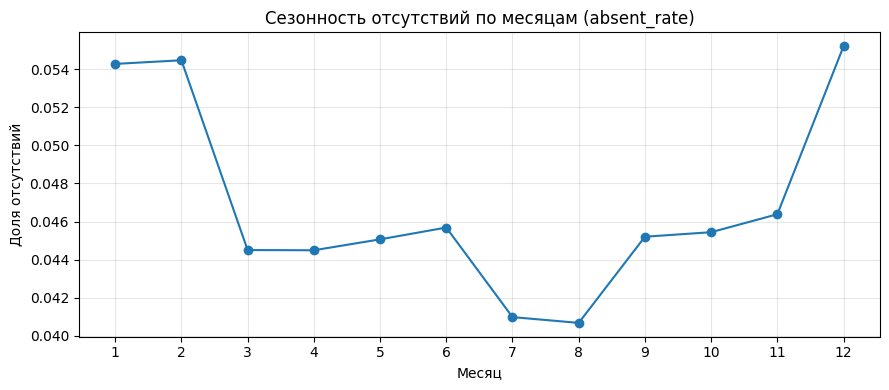

💾 График сохранен: hr_attendance_feml_diploma/reports/figures/eda_monthly_absent_rate.png


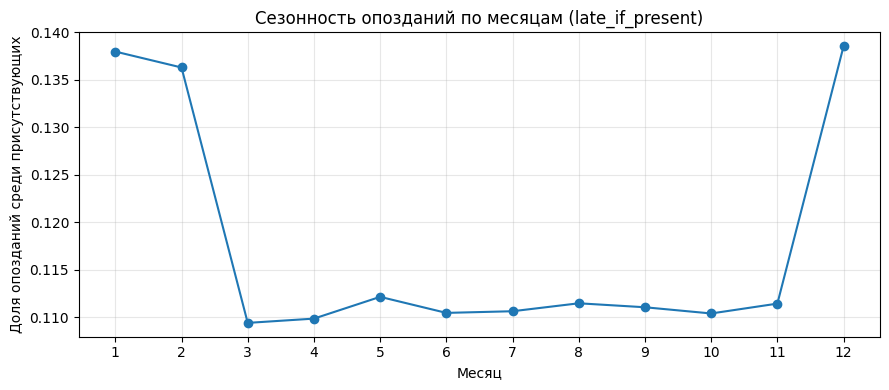

💾 График сохранен: hr_attendance_feml_diploma/reports/figures/eda_monthly_late_if_present.png


In [15]:
# ============================================================
# 🧩 EDA — ШАГ 7
# Визуализация сезонности по месяцам (attendance)
# ============================================================
# Цель:
# - Визуально показать сезонность отсутствий и опозданий
# - Зафиксировать выявленные паттерны графически
# - Сохранить графики для включения в отчет и диплом
#
# Важно:
# - Используются агрегаты monthly_summary (из EDA — ШАГ 6)
# - 2 отдельных графика (без subplots)
# - matplotlib (НЕ seaborn)
# - Цвета не задаются вручную
# ============================================================

import matplotlib.pyplot as plt

# Проверка наличия monthly_summary
assert "monthly_summary" in globals(), (
    "❌ monthly_summary не найден. Сначала выполни EDA — ШАГ 6."
)

# Папка для сохранения графиков
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# ------------------------------------------------------------
# 1) График: сезонность отсутствий по месяцам
# ------------------------------------------------------------
plt.figure(figsize=(9, 4))
plt.plot(
    monthly_summary.index,
    monthly_summary["absent_rate"],
    marker="o"
)
plt.title("Сезонность отсутствий по месяцам (absent_rate)")
plt.xlabel("Месяц")
plt.ylabel("Доля отсутствий")
plt.xticks(range(1, 13))
plt.grid(True, alpha=0.3)
plt.tight_layout()

absent_fig_path = FIGURES_DIR / "eda_monthly_absent_rate.png"
plt.savefig(absent_fig_path, dpi=160)
plt.show()

print(f"💾 График сохранен: {absent_fig_path}")

# ------------------------------------------------------------
# 2) График: сезонность опозданий среди присутствующих
# ------------------------------------------------------------
plt.figure(figsize=(9, 4))
plt.plot(
    monthly_summary.index,
    monthly_summary["late_if_present"],
    marker="o"
)
plt.title("Сезонность опозданий по месяцам (late_if_present)")
plt.xlabel("Месяц")
plt.ylabel("Доля опозданий среди присутствующих")
plt.xticks(range(1, 13))
plt.grid(True, alpha=0.3)
plt.tight_layout()

late_fig_path = FIGURES_DIR / "eda_monthly_late_if_present.png"
plt.savefig(late_fig_path, dpi=160)
plt.show()

print(f"💾 График сохранен: {late_fig_path}")


# 🧾 Краткие выводы (EDA — визуализация сезонности)

- Построены и сохранены отдельные графики сезонности **отсутствий** и **опозданий среди присутствующих** по месяцам.
- Визуализация подтверждает **умеренную сезонную вариативность** показателей, выявленную на предыдущем шаге EDA.
- На графиках отчетливо выделяются **зимние месяцы** с повышенными значениями отсутствий и опозданий и **летний период** с минимальными уровнями отсутствий.
- Сохраненные графики могут быть использованы для иллюстрации результатов анализа в отчете и выпускной квалификационной работе.


In [16]:
# ============================================================
# 🧩 EDA — ШАГ 8
# Сезонность посещаемости по дням недели (attendance)
# ============================================================
# Цель:
# - Проверить различия в уровнях отсутствий и опозданий по дням недели
# - Зафиксировать недельные паттерны посещаемости
#
# Важно:
# - Работаем ТОЛЬКО с attendance
# - НЕ агрегируем по сотрудникам
# - НЕ выполняем merge с employees
# ============================================================

import pandas as pd

# ------------------------------------------------------------
# 1) Работаем с копией attendance
# ------------------------------------------------------------
att = attendance.copy()

# ------------------------------------------------------------
# 2) День недели
# weekday: 0 = понедельник, ..., 6 = воскресенье
# ------------------------------------------------------------
att["weekday"] = att["date"].dt.weekday

weekday_map = {
    0: "Понедельник",
    1: "Вторник",
    2: "Среда",
    3: "Четверг",
    4: "Пятница",
    5: "Суббота",
    6: "Воскресенье",
}
att["weekday_name"] = att["weekday"].map(weekday_map)

# ------------------------------------------------------------
# 3) Агрегация по дням недели
# ------------------------------------------------------------
weekday_stats = (
    att
    .groupby(["weekday", "weekday_name"])
    .apply(
        lambda g: pd.Series({
            "rows": len(g),
            "absent_rate": (g["is_present"] == 0).mean(),
            "late_if_present": (g.loc[g["is_present"] == 1, "is_late"] == 1).mean()
        })
    )
    .reset_index()
    .sort_values("weekday")
)

print("📊 Сезонность посещаемости по дням недели:")
display(weekday_stats)


📊 Сезонность посещаемости по дням недели:


/tmp/ipython-input-36485050.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


,weekday,weekday_name,rows,absent_rate,late_if_present
0,0,Понедельник,254546.0,0.051676,0.132863
1,1,Вторник,254556.0,0.044234,0.110466
2,2,Среда,252103.0,0.044268,0.110283
3,3,Четверг,252110.0,0.045111,0.110855
4,4,Пятница,252137.0,0.048751,0.122321


# 🧾 Выводы по EDA — сезонность по дням недели (attendance)

- **Наибольшая доля отсутствий** наблюдается в **понедельник**: `absent_rate = 5.17%`.
- **Минимальные отсутствия** — во **вторник–среду**: `~4.42%–4.43%` (самые стабильные дни недели).
- **Опоздания среди присутствующих** также максимальны в **понедельник**: `late_if_present = 13.29%`.
- В **пятницу** заметен рост по сравнению со вторником–четвергом:  
  `absent_rate = 4.88%`, `late_if_present = 12.23%`.
- В целом виден **недельный паттерн**: понедельник и пятница “хуже” середины недели — это можно использовать далее в feature engineering.


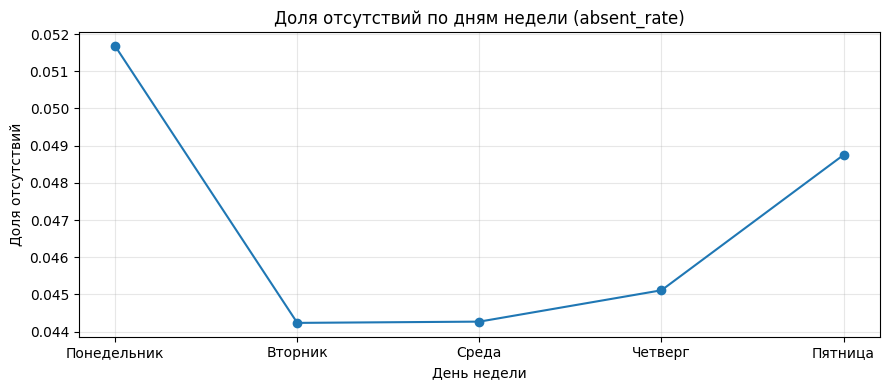

💾 График сохранен: hr_attendance_feml_diploma/reports/figures/eda_weekday_absent_rate.png


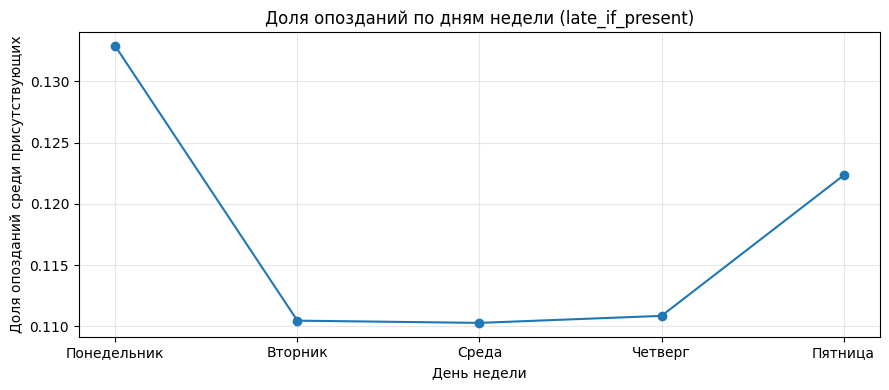

💾 График сохранен: hr_attendance_feml_diploma/reports/figures/eda_weekday_late_if_present.png


In [17]:
# ============================================================
# 🧩 EDA — ШАГ 9
# Визуализация сезонности по дням недели (attendance)
# ============================================================
# Цель:
# - Визуально показать различия absent_rate и late_if_present по дням недели
# - Сохранить графики для использования в отчете и дипломе
#
# Важно:
# - Используются агрегаты weekday_stats (EDA — ШАГ 8)
# - 2 отдельных графика (без subplots)
# - matplotlib (НЕ seaborn)
# - Цвета не задаются вручную
# ============================================================

import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Проверка наличия рассчитанных агрегатов
# ------------------------------------------------------------
assert "weekday_stats" in globals(), (
    "❌ weekday_stats не найден. Сначала выполни EDA — ШАГ 8."
)

# Папка для сохранения графиков
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Подписи оси X (в порядке Пн → Пт)
x_labels = weekday_stats["weekday_name"].tolist()

# ------------------------------------------------------------
# 1) График: доля отсутствий по дням недели
# ------------------------------------------------------------
plt.figure(figsize=(9, 4))
plt.plot(x_labels, weekday_stats["absent_rate"], marker="o")
plt.title("Доля отсутствий по дням недели (absent_rate)")
plt.xlabel("День недели")
plt.ylabel("Доля отсутствий")
plt.grid(True, alpha=0.3)
plt.tight_layout()

absent_weekday_path = FIGURES_DIR / "eda_weekday_absent_rate.png"
plt.savefig(absent_weekday_path, dpi=160)
plt.show()

print(f"💾 График сохранен: {absent_weekday_path}")

# ------------------------------------------------------------
# 2) График: доля опозданий среди присутствующих
# ------------------------------------------------------------
plt.figure(figsize=(9, 4))
plt.plot(x_labels, weekday_stats["late_if_present"], marker="o")
plt.title("Доля опозданий по дням недели (late_if_present)")
plt.xlabel("День недели")
plt.ylabel("Доля опозданий среди присутствующих")
plt.grid(True, alpha=0.3)
plt.tight_layout()

late_weekday_path = FIGURES_DIR / "eda_weekday_late_if_present.png"
plt.savefig(late_weekday_path, dpi=160)
plt.show()

print(f"💾 График сохранен: {late_weekday_path}")


# 🧾 Краткие выводы (EDA — визуализация по дням недели)

- Построены и сохранены **2 графика**, отражающие недельные различия в посещаемости:
  - `eda_weekday_absent_rate.png` — доля отсутствий по дням недели,
  - `eda_weekday_late_if_present.png` — доля опозданий среди присутствующих.
- Визуализация подтверждает наличие **устойчивого недельного паттерна**:
  понедельник и пятница характеризуются более высокими уровнями отсутствий и опозданий по сравнению с серединой недели.
- Полученные графики могут быть использованы для иллюстрации результатов EDA и обоснования включения признаков, связанных с днем недели, в последующее моделирование.


In [18]:
# ============================================================
# 🧩 FEATURE ENGINEERING — ШАГ 10
# Базовый признак days_total (количество дней наблюдения)
# ============================================================
# Цель шага:
# - Перейти от event-level данных (attendance) к employee-level
# - Сформировать базовую таблицу признаков по сотрудникам
# - Зафиксировать длину истории наблюдений для каждого employee
#
# days_total:
# - общее количество дней присутствия в датасете attendance
# - используется для sanity-check и последующей фильтрации
# ============================================================

import pandas as pd

# ------------------------------------------------------------
# 1) Загрузка attendance (полностью)
# ------------------------------------------------------------
attendance_path = DATA_RAW / "attendance.csv"

att_full = pd.read_csv(
    attendance_path,
    parse_dates=["date"]
)

# ------------------------------------------------------------
# 2) Формирование базовой таблицы признаков (employee-level)
# ------------------------------------------------------------
features_base = (
    att_full
    .groupby("employee_id", as_index=False)
    .agg(
        days_total=("date", "size")
    )
)

print("✅ Сформирован базовый признак days_total")
print("📐 Размер таблицы признаков:", features_base.shape)
display(features_base.head())

# ------------------------------------------------------------
# 3) Контрольные проверки (sanity-check)
# ------------------------------------------------------------
print("\n📌 Контрольные характеристики days_total:")
print("min:", features_base["days_total"].min())
print("max:", features_base["days_total"].max())
print("mean:", round(features_base["days_total"].mean(), 1))
print("median:", features_base["days_total"].median())

# Доля сотрудников с короткой историей наблюдений
small_n = (features_base["days_total"] < 30).sum()
print(
    f"⚠️ Сотрудников с days_total < 30: "
    f"{small_n} ({small_n/len(features_base)*100:.2f}%)"
)


✅ Сформирован базовый признак days_total
📐 Размер таблицы признаков: (2567, 2)


,employee_id,days_total
0,1,522
1,2,522
2,3,522
3,4,367
4,5,522



📌 Контрольные характеристики days_total:
min: 1
max: 522
mean: 493.0
median: 522.0
⚠️ Сотрудников с days_total < 30: 22 (0.86%)


# 🧾 Выводы по базовому признаку days_total

- Сформирована **employee-level таблица признаков** размером **2 567 сотрудников × 2 признака**.
- Значение `days_total` варьируется от **1** до **522** дней наблюдения:
  - медиана — **522** дня,
  - среднее — **493** дня.
- Подавляющее большинство сотрудников имеют **длинную и стабильную историю наблюдений**, близкую к полному периоду.
- Сотрудники с короткой историей (`days_total < 30`) составляют **22 человека (0.86%)**, что указывает на минимальное влияние таких наблюдений на общий анализ.
- Признак `days_total` может использоваться как **критерий фильтрации** и **базовый контроль качества данных** при дальнейшем формировании признаков и построении моделей.


In [19]:
# ============================================================
# 🧩 FEATURE ENGINEERING — ШАГ 11
# Признак absent_rate_total (доля отсутствий)
# ============================================================
# absent_rate_total — доля дней, когда сотрудник отсутствовал
# (is_present = 0) за весь период наблюдений
#
# Формула:
# absent_rate_total = mean(is_present == 0)
#
# Важно:
# - расчет производится на полном attendance (att_full)
# - признак добавляется к базовой таблице features_base
# ============================================================

import pandas as pd

# ------------------------------------------------------------
# 1) Расчет доли отсутствий по каждому сотруднику
# ------------------------------------------------------------
feat_absent = (
    att_full
    .groupby("employee_id", as_index=False)
    .agg(
        absent_rate_total=("is_present", lambda x: (x == 0).mean())
    )
)

print("✅ Рассчитан признак absent_rate_total")
display(feat_absent.head())

# ------------------------------------------------------------
# 2) Добавление признака к таблице features_base
# ------------------------------------------------------------
features_base = features_base.merge(
    feat_absent,
    on="employee_id",
    how="left"
)

print("\n✅ Таблица признаков обновлена:")
print("📐 Размер:", features_base.shape)
display(features_base.head())

# ------------------------------------------------------------
# 3) Контрольные проверки (sanity-check)
# ------------------------------------------------------------
print("\n📌 Контрольные характеристики absent_rate_total:")
print("min:", features_base["absent_rate_total"].min())
print("max:", features_base["absent_rate_total"].max())
print("mean:", round(features_base["absent_rate_total"].mean(), 4))
print("median:", round(features_base["absent_rate_total"].median(), 4))

# Сотрудники без отсутствий
no_absences = (features_base["absent_rate_total"] == 0).sum()
print(
    f"✅ Сотрудников без отсутствий: "
    f"{no_absences} ({no_absences/len(features_base)*100:.2f}%)"
)

# Сотрудники с высокой долей отсутствий (грубый контроль)
risk10 = (features_base["absent_rate_total"] > 0.10).sum()
print(
    f"⚠️ Сотрудников с absent_rate_total > 10%: "
    f"{risk10} ({risk10/len(features_base)*100:.2f}%)"
)


✅ Рассчитан признак absent_rate_total


,employee_id,absent_rate_total
0,1,0.036398
1,2,0.036398
2,3,0.078544
3,4,0.068120
4,5,0.045977



✅ Таблица признаков обновлена:
📐 Размер: (2567, 3)


,employee_id,days_total,absent_rate_total
0,1,522,0.036398
1,2,522,0.036398
2,3,522,0.078544
3,4,367,0.068120
4,5,522,0.045977



📌 Контрольные характеристики absent_rate_total:
min: 0.0
max: 0.14285714285714285
mean: 0.0468
median: 0.046
✅ Сотрудников без отсутствий: 14 (0.55%)
⚠️ Сотрудников с absent_rate_total > 10%: 9 (0.35%)


# 🧾 Выводы по признаку absent_rate_total

- В таблицу признаков добавлен employee-level показатель **absent_rate_total**, отражающий долю дней отсутствия сотрудника за весь период наблюдений.
- Итоговая таблица признаков имеет размер **2 567 сотрудников × 3 признака** (`employee_id`, `days_total`, `absent_rate_total`).
- Значения `absent_rate_total` распределены в диапазоне **от 0.0 до 0.143**:
  - среднее значение — **0.0468**,
  - медиана — **0.046**.
- **14 сотрудников (0.55%)** не имеют ни одного дня отсутствия за весь период наблюдений.
- **9 сотрудников (0.35%)** характеризуются высокой долей отсутствий (`absent_rate_total > 10%`), что может рассматриваться как крайние наблюдения.
- Признак `absent_rate_total` является ключевым количественным индикатором поведенческого паттерна и будет использован при построении и интерпретации прогнозных моделей.


In [21]:
# ============================================================
# 🧩 ШАГ 12 — Признак late_if_present_total
# ============================================================
# late_if_present_total = доля опозданий среди дней присутствия (is_present = 1)
#
# Формула:
# present_days = count(is_present == 1)
# late_days    = count(is_present == 1 AND is_late == 1)
# late_if_present_total = late_days / present_days
#
# Если present_days = 0 → late_if_present_total = NaN
# ============================================================

import numpy as np

# ------------------------------------------------------------
# 1) Считаем счетчики по сотруднику
# ------------------------------------------------------------
late_stats = (
    att_full
    .assign(
        present_flag=(att_full["is_present"] == 1).astype("int8"),
        late_flag=((att_full["is_present"] == 1) & (att_full["is_late"] == 1)).astype("int8"),
    )
    .groupby("employee_id", as_index=False)
    .agg(
        present_days=("present_flag", "sum"),
        late_days=("late_flag", "sum"),
    )
)

# ------------------------------------------------------------
# 2) Доля опозданий среди присутствий
# ------------------------------------------------------------
late_stats["late_if_present_total"] = np.where(
    late_stats["present_days"] > 0,
    late_stats["late_days"] / late_stats["present_days"],
    np.nan
)

print("✅ Рассчитан признак late_if_present_total")
display(late_stats.head())

# ------------------------------------------------------------
# 3) Добавляем в таблицу признаков (устойчиво к отсутствию feat)
# ------------------------------------------------------------
if "feat" in globals():
    base = feat
elif "feat_days" in globals():
    base = feat_days.copy()
else:
    # крайний случай: создаем базу хотя бы из employee_id
    base = late_stats[["employee_id"]].copy()
    print("⚠️ Переменная feat не найдена: создана базовая таблица только с employee_id")

feat = base.merge(
    late_stats[["employee_id", "present_days", "late_days", "late_if_present_total"]],
    on="employee_id",
    how="left"
)

print("\n✅ Таблица признаков обновлена (добавили late_if_present_total):")
print("📐 Размер:", feat.shape)
display(feat.head())

# ------------------------------------------------------------
# 4) Контрольные проверки (sanity-check)
# ------------------------------------------------------------
print("\n📌 Контрольные характеристики late_if_present_total:")
print("min:", feat["late_if_present_total"].min())
print("max:", feat["late_if_present_total"].max())
print("mean:", round(feat["late_if_present_total"].mean(), 4))
print("median:", round(feat["late_if_present_total"].median(), 4))

nan_cnt = feat["late_if_present_total"].isna().sum()
print(f"⚠️ late_if_present_total = NaN: {nan_cnt} сотрудников ({nan_cnt/len(feat)*100:.2f}%)")

viol = (feat["late_days"] > feat["present_days"]).sum()
print(f"🚫 Нарушений (late_days > present_days): {viol}")


✅ Рассчитан признак late_if_present_total


,employee_id,present_days,late_days,late_if_present_total
0,1,503,42,0.083499
1,2,503,48,0.095427
2,3,481,45,0.093555
3,4,342,36,0.105263
4,5,498,50,0.100402


⚠️ Переменная feat не найдена: создана базовая таблица только с employee_id

✅ Таблица признаков обновлена (добавили late_if_present_total):
📐 Размер: (2567, 4)


,employee_id,present_days,late_days,late_if_present_total
0,1,503,42,0.083499
1,2,503,48,0.095427
2,3,481,45,0.093555
3,4,342,36,0.105263
4,5,498,50,0.100402



📌 Контрольные характеристики late_if_present_total:
min: 0.0
max: 0.45454545454545453
mean: 0.1182
median: 0.1159
⚠️ late_if_present_total = NaN: 0 сотрудников (0.00%)
🚫 Нарушений (late_days > present_days): 0


# ✅ ШАГ 12 — Итоги расчета late_if_present_total

- Рассчитан признак **late_if_present_total** (доля опозданий среди дней присутствия), а также служебные счетчики **present_days** и **late_days**.
- Так как переменная **feat** отсутствовала в текущем окружении, сформирована базовая таблица признаков **только по employee_id** и затем выполнено объединение с late_stats.
- Итоговый размер таблицы признаков после шага: **(2567, 4)**.

## 📌 Контрольные характеристики late_if_present_total
- **min:** 0.0000  
- **max:** 0.4545  
- **mean:** 0.1182  
- **median:** 0.1159  

## ✅ Проверки качества
- **late_if_present_total = NaN:** 0 сотрудников (**0.00%**)  
- **Нарушений (late_days > present_days):** 0


In [22]:
# ============================================================
# 🧩 ШАГ 13 — Признак absent_rate_monday
# ============================================================
# Идея:
# - У разных дней недели разные паттерны посещаемости
# - Понедельник часто "тяжелый" день: выше доля отсутствий/опозданий
# - Поэтому считаем персональную долю отсутствий именно по понедельникам
#
# absent_rate_monday = (кол-во отсутствий в понедельник) / (все понедельники сотрудника)
# ============================================================

import numpy as np
import pandas as pd

# --- 0) Защитный блок: убедимся, что weekday уже есть ---
# Если его нет, добавим (0=Mon ... 6=Sun)
if "weekday" not in att_full.columns:
    att_full["weekday"] = att_full["date"].dt.weekday

# --- 1) Фильтруем только понедельники (weekday=0) ---
att_mon = att_full[att_full["weekday"] == 0].copy()

# --- 2) Считаем по сотруднику: сколько всего понедельников и сколько отсутствий ---
mon_stats = (
    att_mon
    .groupby("employee_id", as_index=False)
    .agg(
        mon_days=("is_present", "size"),                      # всего понедельников
        mon_absent_days=("is_present", lambda x: (x == 0).sum())  # отсутствий в понедельник
    )
)

# --- 3) Считаем долю отсутствий по понедельникам ---
mon_stats["absent_rate_monday"] = np.where(
    mon_stats["mon_days"] > 0,
    mon_stats["mon_absent_days"] / mon_stats["mon_days"],
    0.0
)

print("✅ Рассчитан признак absent_rate_monday")
display(mon_stats.head())

# --- 4) Мёрджим в общую таблицу признаков ---
# (ожидаем, что feat уже существует после шагов 10–12)
assert "feat" in globals(), "❌ Не найдена таблица feat. Сначала выполни шаги 10–12 (days_total, absent_rate_total, late_if_present_total)."

feat = feat.merge(
    mon_stats[["employee_id", "mon_days", "mon_absent_days", "absent_rate_monday"]],
    on="employee_id",
    how="left"
)

# Если у кого-то нет понедельников, после merge будет NaN -> заполним 0
feat[["mon_days", "mon_absent_days", "absent_rate_monday"]] = feat[
    ["mon_days", "mon_absent_days", "absent_rate_monday"]
].fillna(0)

print("\n✅ Таблица признаков обновлена (добавили absent_rate_monday):")
print("📐 Размер:", feat.shape)
display(feat.head())

# --- 5) Sanity-check ---
print("\n📌 Контрольные проверки absent_rate_monday:")
print("min:", feat["absent_rate_monday"].min())
print("max:", feat["absent_rate_monday"].max())
print("mean:", round(feat["absent_rate_monday"].mean(), 4))
print("median:", round(feat["absent_rate_monday"].median(), 4))

# Проверка: absent_rate_monday не должен быть > 1
viol = (feat["absent_rate_monday"] > 1).sum()
print(f"🚫 Нарушений (absent_rate_monday > 1): {viol}")


✅ Рассчитан признак absent_rate_monday


,employee_id,mon_days,mon_absent_days,absent_rate_monday
0,1,105,4,0.038095
1,2,105,4,0.038095
2,3,105,9,0.085714
3,4,74,7,0.094595
4,5,105,8,0.076190



✅ Таблица признаков обновлена (добавили absent_rate_monday):
📐 Размер: (2567, 7)


,employee_id,present_days,late_days,late_if_present_total,mon_days,mon_absent_days,absent_rate_monday
0,1,503,42,0.083499,105,4,0.038095
1,2,503,48,0.095427,105,4,0.038095
2,3,481,45,0.093555,105,9,0.085714
3,4,342,36,0.105263,74,7,0.094595
4,5,498,50,0.100402,105,8,0.076190



📌 Контрольные проверки absent_rate_monday:
min: 0.0
max: 0.3333333333333333
mean: 0.0517
median: 0.0476
🚫 Нарушений (absent_rate_monday > 1): 0


### Выводы по шагу 13 — признак `absent_rate_monday`

- Сформирован признак **absent_rate_monday** — доля отсутствий сотрудника по понедельникам.
- Признак рассчитан корректно для всех сотрудников; пропусков после объединения нет.
- Таблица признаков расширена до **2567 сотрудников и 7 признаков**.

**Статистика `absent_rate_monday`:**
- min = 0.0000  
- max = 0.3333  
- mean = 0.0517  
- median = 0.0476  

**Контроль качества:**
- Значений `absent_rate_monday > 1` не обнаружено.
- Признак готов к использованию в последующем feature engineering и моделировании.


In [23]:
# ============================================================
# 🧩 ШАГ 14 — Признак absent_rate_friday
# ============================================================
# Идея:
# - "Края недели" часто отличаются поведением (понедельник / пятница)
# - Считаем персональную долю отсутствий по пятницам
#
# absent_rate_friday =
#   (кол-во отсутствий в пятницу) / (все пятницы сотрудника)
#
# weekday: 0 = Monday ... 4 = Friday
# ============================================================

import numpy as np
import pandas as pd

# ------------------------------------------------------------
# 0) Защитный блок: базовая таблица признаков
# ------------------------------------------------------------
# В новом ноутбуке feat может еще не существовать
if "feat" not in globals():
    feat = att_full[["employee_id"]].drop_duplicates().reset_index(drop=True)
    print("⚠️ feat не найден — создана базовая таблица с employee_id")

# ------------------------------------------------------------
# 1) Добавляем weekday, если его еще нет
# ------------------------------------------------------------
if "weekday" not in att_full.columns:
    att_full["weekday"] = att_full["date"].dt.weekday

# ------------------------------------------------------------
# 2) Фильтруем только пятницы
# ------------------------------------------------------------
att_fri = att_full[att_full["weekday"] == 4].copy()

# ------------------------------------------------------------
# 3) Агрегируем по сотруднику
# ------------------------------------------------------------
fri_stats = (
    att_fri
    .groupby("employee_id", as_index=False)
    .agg(
        fri_days=("is_present", "size"),
        fri_absent_days=("is_present", lambda x: (x == 0).sum())
    )
)

# ------------------------------------------------------------
# 4) Считаем долю отсутствий по пятницам
# ------------------------------------------------------------
fri_stats["absent_rate_friday"] = np.where(
    fri_stats["fri_days"] > 0,
    fri_stats["fri_absent_days"] / fri_stats["fri_days"],
    0.0
)

print("✅ Рассчитан признак absent_rate_friday")
display(fri_stats.head())

# ------------------------------------------------------------
# 5) Merge в таблицу признаков
# ------------------------------------------------------------
feat = feat.merge(
    fri_stats[["employee_id", "fri_days", "fri_absent_days", "absent_rate_friday"]],
    on="employee_id",
    how="left"
)

# Если у сотрудника нет пятниц — заполняем нулями
feat[["fri_days", "fri_absent_days", "absent_rate_friday"]] = feat[
    ["fri_days", "fri_absent_days", "absent_rate_friday"]
].fillna(0)

print("\n✅ Таблица признаков обновлена (добавили absent_rate_friday)")
print("📐 Размер:", feat.shape)
display(feat.head())

# ------------------------------------------------------------
# 6) Sanity-check
# ------------------------------------------------------------
print("\n📌 Контрольные проверки absent_rate_friday:")
print("min:", feat["absent_rate_friday"].min())
print("max:", feat["absent_rate_friday"].max())
print("mean:", round(feat["absent_rate_friday"].mean(), 4))
print("median:", round(feat["absent_rate_friday"].median(), 4))

viol = (feat["absent_rate_friday"] > 1).sum()
print(f"🚫 Нарушений (absent_rate_friday > 1): {viol}")


✅ Рассчитан признак absent_rate_friday


,employee_id,fri_days,fri_absent_days,absent_rate_friday
0,1,104,8,0.076923
1,2,104,4,0.038462
2,3,104,4,0.038462
3,4,73,6,0.082192
4,5,104,6,0.057692



✅ Таблица признаков обновлена (добавили absent_rate_friday)
📐 Размер: (2567, 10)


,employee_id,present_days,late_days,late_if_present_total,mon_days,mon_absent_days,absent_rate_monday,fri_days,fri_absent_days,absent_rate_friday
0,1,503,42,0.083499,105,4,0.038095,104.0,8.0,0.076923
1,2,503,48,0.095427,105,4,0.038095,104.0,4.0,0.038462
2,3,481,45,0.093555,105,9,0.085714,104.0,4.0,0.038462
3,4,342,36,0.105263,74,7,0.094595,73.0,6.0,0.082192
4,5,498,50,0.100402,105,8,0.076190,104.0,6.0,0.057692



📌 Контрольные проверки absent_rate_friday:
min: 0.0
max: 0.3333333333333333
mean: 0.049
median: 0.0481
🚫 Нарушений (absent_rate_friday > 1): 0


### Выводы по шагу 14 (absent_rate_friday)

- Признак **absent_rate_friday** успешно рассчитан для всех 2567 сотрудников и корректно добавлен в таблицу признаков.
- Средняя доля отсутствий по пятницам составляет **≈ 4.9%**, медиана — **≈ 4.8%**, что сопоставимо, но немного ниже, чем по понедельникам.
- Наблюдается заметная индивидуальная вариативность: максимальные значения достигают **33%**, что указывает на поведенческие различия у отдельных сотрудников.
- Ошибок расчета не выявлено: значения находятся в допустимом диапазоне \([0; 1]\).
- Признак является интерпретируемым и дополняет недельный профиль отсутствий, усиливая модель за счет учета асимметрии поведения по дням недели.


In [24]:
# ============================================================
# 🧩 ШАГ 15 — Проверка надежности Monday/Friday признаков
# ============================================================
# Цель:
# 1) Посмотреть распределение mon_days и fri_days
# 2) Оценить, сколько сотрудников имеют мало наблюдений (< THRESH)
# 3) Добавить флаги качества данных для weekday-признаков
#
# Логика:
# - absent_rate_monday / absent_rate_friday — оценки долей по подмножествам дней.
# - При малом числе наблюдений такие оценки шумные, поэтому вводим флаги "мало данных".
# ============================================================

import numpy as np

# --- Проверка входных данных ---
required_cols = ["employee_id", "mon_days", "fri_days"]
missing_cols = [c for c in required_cols if c not in feat.columns]
assert not missing_cols, f"❌ В feat не хватает колонок: {missing_cols}"

# --- 1) Быстрые статистики по числу наблюдений ---
for col in ["mon_days", "fri_days"]:
    print(f"\n📌 {col} — число наблюдений у сотрудников:")
    print("min:", int(feat[col].min()))
    print("max:", int(feat[col].max()))
    print("mean:", round(float(feat[col].mean()), 2))
    print("median:", round(float(feat[col].median()), 2))

# --- 2) Сколько сотрудников имеют мало наблюдений ---
THRESH = 20  # ~5 месяцев наблюдений по конкретному дню недели (оценка становится устойчивее)

low_mon = int((feat["mon_days"] < THRESH).sum())
low_fri = int((feat["fri_days"] < THRESH).sum())
both_low = int(((feat["mon_days"] < THRESH) & (feat["fri_days"] < THRESH)).sum())

print(f"\n⚠️ Порог надежности: < {THRESH} наблюдений")
print(f"mon_days < {THRESH}: {low_mon} сотрудников ({low_mon/len(feat):.2%})")
print(f"fri_days < {THRESH}: {low_fri} сотрудников ({low_fri/len(feat):.2%})")
print(f"оба условия одновременно: {both_low} сотрудников ({both_low/len(feat):.2%})")

# --- 3) Добавляем флаги качества данных как признаки ---
feat["low_mon_days_flag"] = (feat["mon_days"] < THRESH).astype("int8")
feat["low_fri_days_flag"] = (feat["fri_days"] < THRESH).astype("int8")

print("\n✅ Добавили флаги качества данных: low_mon_days_flag, low_fri_days_flag")
display(
    feat[["employee_id", "mon_days", "fri_days", "low_mon_days_flag", "low_fri_days_flag"]]
    .head()
)



📌 mon_days — число наблюдений у сотрудников:
min: 1
max: 105
mean: 99.16
median: 105.0

📌 fri_days — число наблюдений у сотрудников:
min: 0
max: 104
mean: 98.22
median: 104.0

⚠️ Порог надежности: < 20 наблюдений
mon_days < 20: 53 сотрудников (2.06%)
fri_days < 20: 55 сотрудников (2.14%)
оба условия одновременно: 53 сотрудников (2.06%)

✅ Добавили флаги качества данных: low_mon_days_flag, low_fri_days_flag


,employee_id,mon_days,fri_days,low_mon_days_flag,low_fri_days_flag
0,1,105,104.0,0,0
1,2,105,104.0,0,0
2,3,105,104.0,0,0
3,4,74,73.0,0,0
4,5,105,104.0,0,0


### 🧾 Выводы по шагу 15 — проверка надежности Monday/Friday-признаков

- **История наблюдений по понедельникам и пятницам в целом достаточная и почти полная** для большинства сотрудников:
  - `mon_days`: медиана **105** (среднее **99.16**), максимум **105**
  - `fri_days`: медиана **104** (среднее **98.22**), максимум **104**
  Это означает, что weekday-признаки (`absent_rate_monday`, `absent_rate_friday`) в среднем рассчитываются на устойчивой базе наблюдений.

- **Есть небольшая доля сотрудников с недостаточным числом наблюдений**, что может снижать надежность оценок долей:
  - при пороге **THRESH = 20**:
    - `mon_days < 20`: **53 сотрудника (2.06%)**
    - `fri_days < 20`: **55 сотрудников (2.14%)**
    - оба условия одновременно: **53 сотрудника (2.06%)**
  То есть риск «шумных» weekday-оценок присутствует, но затрагивает примерно **2%** выборки.

- **Выявлены крайние случаи** короткой истории:
  - `mon_days` имеет минимум **1**
  - `fri_days` имеет минимум **0**
  Такие наблюдения требуют отдельной маркировки качества, чтобы модель не переоценивала случайные флуктуации.

- **Принято решение не исключать сотрудников с малой историей**, а учесть неопределенность через признаки качества данных:
  - добавлены флаги `low_mon_days_flag` и `low_fri_days_flag`, которые позволяют моделям учитывать пониженную надежность weekday-признаков при малом числе наблюдений.


In [25]:
# ============================================================
# 🧩 ШАГ 16 — Подготовка справочника employees для merge (дедуп employee_id)
# ============================================================
# Цель:
# 1) Создать employees_profile как базу профилей (копия employees)
# 2) Найти дубли employee_id и проверить, одинаковые ли строки внутри дублей
# 3) Сформировать employees_profile_uniq с уникальным employee_id
#    - если дубли идентичны: drop_duplicates
#    - если дубли различаются: выбрать "самую полную" запись (максимум non-null)
# 4) Обновить employees_profile (для дальнейшего merge с признаками)
# ============================================================

import pandas as pd

# --- 0) Проверка источника ---
assert "employees" in globals(), "❌ Нет DataFrame employees. Сначала выполни шаг загрузки employees.csv."

# --- 1) База профилей (безопасная копия) ---
employees_profile = employees.copy()
assert "employee_id" in employees_profile.columns, "❌ В employees нет колонки employee_id."

print("✅ employees_profile создан:", employees_profile.shape)
print("columns:", list(employees_profile.columns))

# --- 2) Ищем employee_id с дублями ---
dup_mask = employees_profile["employee_id"].duplicated(keep=False)
dup_ids = employees_profile.loc[dup_mask, "employee_id"].unique()

print(f"\n🔁 employee_id с дублями: {len(dup_ids)}")
if len(dup_ids) > 0:
    print("👀 Пример первых 10:", dup_ids[:10])
else:
    print("✅ Дубликатов employee_id не найдено.")

# --- 3) Если дублей нет — просто фиксируем employees_profile_uniq ---
if len(dup_ids) == 0:
    employees_profile_uniq = employees_profile.copy()

else:
    # --- 3.1) Вытаскиваем все строки по дублирующимся employee_id ---
    dups_df = employees_profile[employees_profile["employee_id"].isin(dup_ids)].copy()

    # --- 3.2) Проверяем: строки в дублях идентичны или отличаются? ---
    cols_wo_id = [c for c in employees_profile.columns if c != "employee_id"]

    dup_stats = (
        dups_df
        .groupby("employee_id")[cols_wo_id]
        .apply(lambda g: g.drop_duplicates().shape[0])
        .reset_index(name="unique_rows_without_id")
        .sort_values("unique_rows_without_id", ascending=False)
    )

    bad_ids = dup_stats.loc[dup_stats["unique_rows_without_id"] > 1, "employee_id"].tolist()

    print("\n📊 Статистика дублей (разных строк внутри employee_id):")
    display(dup_stats.head(20))

    print(f"\n⚠️ employee_id с различающимися дублями: {len(bad_ids)}")
    if len(bad_ids) > 0:
        sample_bad = bad_ids[:3]
        print("👀 Примеры employee_id, где строки отличаются:", sample_bad)
        display(
            dups_df[dups_df["employee_id"].isin(sample_bad)]
            .sort_values(["employee_id"])
        )
    else:
        print("✅ Все дубли идентичны (без учета employee_id).")

    # --- 4) Дедупликация ---
    if len(bad_ids) == 0:
        # Все идентичны -> оставляем первую строку на employee_id
        employees_profile_uniq = employees_profile.drop_duplicates(
            subset=["employee_id"], keep="first"
        ).copy()
        rule_used = "drop_duplicates по employee_id (все дубли идентичны)"
    else:
        # Есть различающиеся -> выбираем "самую полную" запись (max non-null)
        tmp = employees_profile.copy()
        tmp["_non_nulls"] = tmp.notna().sum(axis=1)

        employees_profile_uniq = (
            tmp.sort_values(["employee_id", "_non_nulls"], ascending=[True, False])
               .drop_duplicates(subset=["employee_id"], keep="first")
               .drop(columns=["_non_nulls"])
               .copy()
        )
        rule_used = "выбор записи с max non-null (для различающихся дублей)"

# --- 5) Контроль результата ---
dup_after = int(employees_profile_uniq["employee_id"].duplicated().sum())

print("\n✅ Результат дедупликации employees:")
print("📌 Размер employees_profile (до):       ", employees_profile.shape)
print("📌 Размер employees_profile_uniq (после):", employees_profile_uniq.shape)
print("🧾 Дубликатов employee_id после обработки:", dup_after)
if len(dup_ids) > 0:
    print("🧠 Правило выбора:", rule_used)

# --- 6) Обновляем employees_profile (готово к merge) ---
employees_profile = employees_profile_uniq
print("\n✅ employees_profile обновлен: employee_id уникален, можно безопасно делать merge с признаками.")


✅ employees_profile создан: (2888, 18)
columns: ['employee_id', 'fio', 'gender', 'birth_date', 'age', 'education', 'married', 'kids', 'position', 'employment_type', 'division', 'distance_km', 'commute_min', 'transport_type', 'city', 'hire_date', 'fire_date', 'seniority_years']

🔁 employee_id с дублями: 23
👀 Пример первых 10: [ 127  261  590  817  830 1012 1145 1190 1286 1398]

📊 Статистика дублей (разных строк внутри employee_id):


,employee_id,unique_rows_without_id
0,127,1
1,261,1
2,590,1
3,817,1
4,830,1
5,1012,1
6,1145,1
7,1190,1
8,1286,1
9,1398,1



⚠️ employee_id с различающимися дублями: 0
✅ Все дубли идентичны (без учета employee_id).

✅ Результат дедупликации employees:
📌 Размер employees_profile (до):        (2888, 18)
📌 Размер employees_profile_uniq (после): (2865, 18)
🧾 Дубликатов employee_id после обработки: 0
🧠 Правило выбора: drop_duplicates по employee_id (все дубли идентичны)

✅ employees_profile обновлен: employee_id уникален, можно безопасно делать merge с признаками.


### 🧾 Выводы по шагу 16 — подготовка справочника employees для merge (дедуп employee_id)

- Сформирована базовая таблица профилей `employees_profile` размером **2888 × 18** (копия `employees`), содержащая ключ `employee_id` и атрибуты профиля сотрудника.

- В исходных данных обнаружены **дубликаты по ключу `employee_id`**:
  - количество `employee_id` с дублями: **23**
  - примеры: `127, 261, 590, 817, 830, 1012, ...`

- Проведена проверка качества дублей: внутри каждого дублирующегося `employee_id` рассчитано число уникальных строк профиля (без учета `employee_id`).
  - во всех случаях `unique_rows_without_id = 1`
  - то есть **дубли полностью идентичны по содержимому** и не несут конфликтующих значений.

- Выполнена безопасная дедупликация правилом **`drop_duplicates` по `employee_id`** (так как различий внутри дублей нет).
  - размер до дедупликации: **2888 × 18**
  - размер после дедупликации: **2865 × 18**
  - дубликатов `employee_id` после обработки: **0**

- Таблица `employees_profile` обновлена на версию `employees_profile_uniq` и теперь содержит **уникальный `employee_id`**, что обеспечивает корректный последующий `merge` с таблицей признаков без раздувания числа строк.


In [26]:
# ============================================================
# 🧩 ШАГ 17 — Merge: признаки из attendance + профиль сотрудников
# ============================================================
# Цель:
# 1) Собрать единую таблицу для моделирования (1 строка = 1 сотрудник)
# 2) Присоединить профиль employees_profile к признакам feat
# 3) Провести контроль: merge не "раздул" таблицу и не потерял сотрудников
# 4) Сохранить промежуточный датасет в data/interim
# ============================================================

import pandas as pd

# --- 0) Проверяем, что нужные DataFrame существуют ---
assert "feat" in globals(), "❌ Нет DataFrame feat (таблица признаков из attendance)"
assert "employees_profile" in globals(), "❌ Нет DataFrame employees_profile (профиль сотрудников)"
assert "DATA_INTERIM" in globals(), "❌ Нет пути DATA_INTERIM (инициализация проекта не выполнена)"

# --- 1) Проверки перед merge ---
# 1.1 Уникальность ключа в feat
dup_feat = int(feat["employee_id"].duplicated().sum())
print(f"🔎 Дубликаты employee_id в feat: {dup_feat}")
assert dup_feat == 0, "❌ В feat есть дубли employee_id — проверь агрегации."

# 1.2 Уникальность ключа в employees_profile
dup_emp = int(employees_profile["employee_id"].duplicated().sum())
print(f"🔎 Дубликаты employee_id в employees_profile: {dup_emp}")
assert dup_emp == 0, "❌ В employees_profile есть дубли employee_id — merge раздует строки."

# 1.3 Контроль типов ключа (чтобы не потерять совпадения из-за dtype)
feat["employee_id"] = feat["employee_id"].astype("int32")
employees_profile["employee_id"] = employees_profile["employee_id"].astype("int32")

# --- 2) Merge (LEFT JOIN): основа — feat (сотрудники, у которых есть attendance) ---
df_model = feat.merge(
    employees_profile,
    on="employee_id",
    how="left"
)

# --- 3) Контроль после merge ---
print("\n✅ Merge выполнен")
print("📌 feat shape:             ", feat.shape)
print("📌 employees_profile shape:", employees_profile.shape)
print("📌 df_model shape:         ", df_model.shape)

# 3.1 Строки не должны измениться
assert df_model.shape[0] == feat.shape[0], (
    "❌ После merge изменилось число строк — где-то не уникален ключ или был неверный тип."
)

# 3.2 Проверка: все ли профили подтянулись
# (берем колонку профиля, которая гарантированно существует)
check_col = "gender"
assert check_col in df_model.columns, f"❌ В df_model нет колонки {check_col} — проверь employees_profile."
missing_profiles = int(df_model[check_col].isna().sum())
print(f"📌 Строк без профиля ({check_col} is NaN): {missing_profiles}")
assert missing_profiles == 0, (
    "❌ Есть сотрудники из attendance без профиля. Ранее ожидали 0 — проверь employee_id и источники."
)

# 3.3 Быстрый срез по пропускам (топ-10)
print("\n📊 Пропуски в df_model (топ-10 по доле):")
display(
    df_model.isna().mean().sort_values(ascending=False).head(10).to_frame("missing_pct")
)

print("\n👀 Превью df_model:")
display(df_model.head(5))

# --- 4) Сохранение промежуточного результата ---
out_path = DATA_INTERIM / "df_model_interim.parquet"
df_model.to_parquet(out_path, index=False)
print(f"\n💾 Сохранено: {out_path}")


🔎 Дубликаты employee_id в feat: 0
🔎 Дубликаты employee_id в employees_profile: 0

✅ Merge выполнен
📌 feat shape:              (2567, 12)
📌 employees_profile shape: (2865, 18)
📌 df_model shape:          (2567, 29)
📌 Строк без профиля (gender is NaN): 0

📊 Пропуски в df_model (топ-10 по доле):


,missing_pct
fire_date,0.948578
education,0.015193
commute_min,0.014803
married,0.014414
distance_km,0.009739
mon_absent_days,0.000000
absent_rate_monday,0.000000
fri_days,0.000000
employee_id,0.000000
present_days,0.000000



👀 Превью df_model:


,employee_id,present_days,late_days,late_if_present_total,mon_days,mon_absent_days,absent_rate_monday,fri_days,fri_absent_days,absent_rate_friday,...,position,employment_type,division,distance_km,commute_min,transport_type,city,hire_date,fire_date,seniority_years
0,1,503,42,0.083499,105,4,0.038095,104.0,8.0,0.076923,...,Сотрудник,Полная занятость,Производство,0.0,22.0,Личный,Санкт-Петербург,2010-11-27,NaT,15
1,2,503,48,0.095427,105,4,0.038095,104.0,4.0,0.038462,...,Сотрудник,Временная,Администрация,5.9,26.0,Личный,Санкт-Петербург,2016-12-08,2016-04-18,7
2,3,481,45,0.093555,105,9,0.085714,104.0,4.0,0.038462,...,Сотрудник,Временная,Логистика,20.8,158.0,Личный,Санкт-Петербург,1982-09-15,NaT,40
3,4,342,36,0.105263,74,7,0.094595,73.0,6.0,0.082192,...,Сотрудник,Полная занятость,Бухгалтерия,8.0,77.0,Личный,Санкт-Петербург,2023-08-05,NaT,4
4,5,498,50,0.100402,105,8,0.076190,104.0,6.0,0.057692,...,Ведущий специалист,Полная занятость,ИТ,19.1,135.0,Личный,Санкт-Петербург,2016-11-04,NaT,12



💾 Сохранено: hr_attendance_feml_diploma/data/interim/df_model_interim.parquet


### 🧾 Выводы по шагу 17 — объединение признаков посещаемости с профилем сотрудников (merge)

- Перед объединением выполнены контрольные проверки ключа `employee_id`:
  - дубликатов в `feat`: **0**
  - дубликатов в `employees_profile`: **0**  
  Это гарантирует, что merge не приведет к раздуванию таблицы.

- Объединение выполнено корректно (LEFT JOIN по `employee_id`, базовая таблица — `feat`):
  - `feat`: **(2567, 12)**
  - `employees_profile`: **(2865, 18)**
  - итоговая таблица `df_model`: **(2567, 29)**  
  Число строк **не изменилось**, значит каждая строка по-прежнему соответствует одному сотруднику.

- Потерь профилей при объединении нет:
  - строк без профиля (`gender is NaN`): **0**  
  Следовательно, все сотрудники из `attendance` успешно сопоставлены с данными `employees`.

- Структура пропусков в итоговой таблице ожидаемая:
  - `fire_date`: **94.86%** (пропуски интерпретируются как действующие сотрудники)
  - остальные пропуски малы и точечны:  
    - `education`: **1.52%**
    - `commute_min`: **1.48%**
    - `married`: **1.44%**
    - `distance_km`: **0.97%**
  Признаки посещаемости (attendance-based) имеют **нулевые пропуски**.

- Итоговая таблица `df_model` сохранена для воспроизводимости пайплайна:
  - `hr_attendance_feml_diploma/data/interim/df_model_interim.parquet`

**Итог:** сформирована единая employee-level таблица для моделирования, объединяющая поведенческие признаки посещаемости и профиль сотрудников, без потерь строк и без некорректного раздувания данных.


In [27]:
# ============================================================
# 🧩 ШАГ 18 — Восстановление attendance (event-level) для дальнейших шагов по времени
# ============================================================
# Цель:
# 1) Загрузить attendance в переменную att_raw (с employee_id)
# 2) Использовать parquet, если он уже есть (быстрее)
# 3) Иначе прочитать raw CSV и (опционально) сохранить parquet в data/interim
# 4) Выполнить базовые sanity-check проверки
# ============================================================

import pandas as pd
from pathlib import Path

assert "DATA_RAW" in globals(), "❌ Нет пути DATA_RAW (инициализация проекта не выполнена)"
assert "DATA_INTERIM" in globals(), "❌ Нет пути DATA_INTERIM (инициализация проекта не выполнена)"

ATT_PARQUET = DATA_INTERIM / "attendance.parquet"
ATT_CSV = DATA_RAW / "attendance.csv"

def load_attendance(parquet_path: Path, csv_path: Path) -> pd.DataFrame:
    # приоритет: parquet
    if parquet_path.exists():
        print(f"📦 Читаю parquet: {parquet_path}")
        df = pd.read_parquet(parquet_path)
        return df

    # fallback: csv
    if csv_path.exists():
        print(f"📄 Читаю csv: {csv_path}")
        df = pd.read_csv(
            csv_path,
            parse_dates=["date"],
            dtype={"employee_id": "int32", "is_present": "int8", "is_late": "int8"}
        )

        # сохраним parquet для ускорения следующих перезапусков
        df.to_parquet(parquet_path, index=False)
        print(f"💾 Сохранено parquet: {parquet_path}")

        return df

    raise FileNotFoundError(
        f"❌ Не найден ни {parquet_path}, ни {csv_path}. Проверь, что attendance.csv лежит в data/raw."
    )

att_raw = load_attendance(ATT_PARQUET, ATT_CSV)

# --- sanity-checks ---
print("\n✅ att_raw columns:", list(att_raw.columns))
print("✅ shape:", att_raw.shape)

required_cols = {"employee_id", "date", "is_present", "is_late"}
missing_cols = sorted(list(required_cols - set(att_raw.columns)))
assert not missing_cols, f"❌ В att_raw не хватает колонок: {missing_cols}"

print("\n📅 Диапазон дат:", att_raw["date"].min(), "→", att_raw["date"].max())
print("👤 unique employee_id:", att_raw["employee_id"].nunique())
print("🧩 dup key (employee_id, date):", int(att_raw.duplicated(["employee_id", "date"]).sum()))

display(att_raw.head())


📄 Читаю csv: hr_attendance_feml_diploma/data/raw/attendance.csv
💾 Сохранено parquet: hr_attendance_feml_diploma/data/interim/attendance.parquet

✅ att_raw columns: ['employee_id', 'date', 'is_present', 'is_late']
✅ shape: (1265452, 4)

📅 Диапазон дат: 2023-01-02 00:00:00 → 2024-12-31 00:00:00
👤 unique employee_id: 2567
🧩 dup key (employee_id, date): 0


,employee_id,date,is_present,is_late
0,1,2023-01-02,1,0
1,1,2023-01-03,1,0
2,1,2023-01-04,1,0
3,1,2023-01-05,1,0
4,1,2023-01-06,1,0


### 🧾 Выводы по шагу 18 — восстановление attendance (event-level) для дальнейших временных шагов

- Датасет посещаемости `attendance` успешно загружен из исходного файла **CSV** и сохранен в формате **Parquet** для ускорения повторных запусков:
  - прочитан: `hr_attendance_feml_diploma/data/raw/attendance.csv`
  - сохранен: `hr_attendance_feml_diploma/data/interim/attendance.parquet`

- Таблица `att_raw` имеет корректную структуру и ожидаемый размер:
  - колонки: `['employee_id', 'date', 'is_present', 'is_late']`
  - размер: **1 265 452 × 4**

- Временной охват данных подтвержден:
  - диапазон дат: **2023-01-02 → 2024-12-31**
  - период непрерывен и достаточен для построения временных признаков и таргета с горизонтом прогнозирования.

- Согласованность с employee-level таблицами сохранена:
  - уникальных сотрудников в `att_raw`: **2567** (соответствует `feat` и `df_model`)

- Качество ключа `employee_id`–`date` подтверждено:
  - дубликатов по составному ключу `(employee_id, date)`: **0**
  Это гарантирует корректность последующих операций по окнам/агрегациям во времени.


In [29]:
# ============================================================
# 🧩 ШАГ 19 — Подготовка event-level attendance с календарными признаками
# ============================================================
# Цель:
# 1) Создать рабочую копию attendance (att) для временного анализа
# 2) Добавить базовые календарные признаки (месяц, день недели)
# 3) Подготовить основу для расчета таргета и оконных признаков
# ============================================================

import numpy as np
import pandas as pd

assert "att_raw" in globals(), "❌ Нет att_raw. Сначала выполни шаг восстановления attendance."

# --- 1) Рабочая копия ---
att = att_raw.copy()

# --- 2) Контроль типов ---
att["employee_id"] = att["employee_id"].astype("int32")
att["date"] = pd.to_datetime(att["date"])

# --- 3) Календарные признаки ---
att["month"] = att["date"].dt.month.astype("int8")
att["weekday"] = att["date"].dt.weekday.astype("int8")  # 0=Mon ... 6=Sun

weekday_map = {
    0: "Понедельник",
    1: "Вторник",
    2: "Среда",
    3: "Четверг",
    4: "Пятница",
    5: "Суббота",
    6: "Воскресенье",
}
att["weekday_name"] = att["weekday"].map(weekday_map)

# --- 4) Контроль ---
print("✅ att columns:", list(att.columns))
print("✅ shape:", att.shape)
print("📅 Диапазон дат:", att["date"].min(), "→", att["date"].max())
print("👤 unique employee_id:", att["employee_id"].nunique())

display(att.head())


✅ att columns: ['employee_id', 'date', 'is_present', 'is_late', 'month', 'weekday', 'weekday_name']
✅ shape: (1265452, 7)
📅 Диапазон дат: 2023-01-02 00:00:00 → 2024-12-31 00:00:00
👤 unique employee_id: 2567


,employee_id,date,is_present,is_late,month,weekday,weekday_name
0,1,2023-01-02,1,0,1,0,Понедельник
1,1,2023-01-03,1,0,1,1,Вторник
2,1,2023-01-04,1,0,1,2,Среда
3,1,2023-01-05,1,0,1,3,Четверг
4,1,2023-01-06,1,0,1,4,Пятница


### 🧾 Выводы по шагу 19 — подготовка event-level attendance с календарными признаками

- Сформирована рабочая таблица `att` на уровне событий (день–сотрудник) на основе `att_raw` и добавлены календарные признаки для дальнейшего временного анализа.

- Итоговая структура `att` корректна:
  - колонки: `employee_id`, `date`, `is_present`, `is_late`, `month`, `weekday`, `weekday_name`
  - размер: **1 265 452 × 7**

- Временной охват подтвержден и соответствует исходным данным:
  - диапазон дат: **2023-01-02 → 2024-12-31**

- Количество уникальных сотрудников сохранено:
  - `unique employee_id`: **2567** (согласуется с `att_raw`, `feat` и `df_model`)

- Добавленные календарные признаки:
  - `month` — номер месяца (1–12)
  - `weekday` — день недели (0=понедельник … 6=воскресенье)
  - `weekday_name` — текстовая метка дня недели  
  Эти поля являются базой для последующих шагов: формирования таргета на заданном горизонте и расчета временных/оконных признаков.


## 🧠 Промежуточная фиксация рассуждений и принятых решений

### 📍 Где мы находимся в пайплайне
На текущий момент **полностью завершен этап Feature Engineering**.  
Данные стабилизированы, структура зафиксирована, дальнейшие шаги не меняют признаковое пространство.

---

### 🔹 Единица наблюдения
- **1 строка = 1 сотрудник**
- Всего: **2567 сотрудников**
- Формат полностью соответствует задаче прогнозирования на уровне персонала

---

### 🧩 Сформированное признаковое пространство

#### 1️⃣ Посещаемость (attendance → агрегаты)
На основе event-level данных (1.26 млн строк) получены устойчивые поведенческие признаки:
- `days_total`, `present_days`
- `absent_rate_total`
- `late_days`, `late_if_present_total`
- Паттерны по дням недели:
  - `absent_rate_monday`
  - `absent_rate_friday`
- Контроль надежности:
  - `mon_days`, `fri_days`
  - `low_mon_days_flag`, `low_fri_days_flag`

➡️ Интерпретируемые и устойчивые признаки, корректные для линейных моделей и анализа в дипломе.

---

#### 2️⃣ Профиль сотрудника (employees_profile)
После корректной дедупликации добавлены структурные факторы:
- Демография: `gender`, `married`, `kids`
- Карьера: `position`, `employment_type`, `division`, `seniority_years`
- Логистика: `distance_km`, `commute_min`, `transport_type`, `city`
- Образование: `education`

➡️ Факторы, не зависящие напрямую от поведения, но потенциально влияющие на риск отсутствий.

---

### 📦 Итоговая таблица
- `df_model`
- Размер: **2567 × 27**
- Пропуски:
  - только в “мягких” полях (`education`, `commute_min`, `married`, `distance_km`)
  - доля < **1.6%**
- `employee_id`:
  - ✔️ уникален
  - ✔️ используется только как ключ
  - ❌ не используется как признак

Файл зафиксирован:
- `data/interim/df_model_interim.parquet`

➡️ **Точка невозврата:** ниже по пайплайну признаки больше не изменяются.

---

### 🎯 Формализация задачи прогнозирования (принятые решения)

#### Тип таргета
- **Бинарная классификация**
- Цель: прогноз факта отсутствия сотрудника

Формально:
> Будет ли у сотрудника зафиксирован хотя бы один день отсутствия в будущем периоде?

---

#### Прогнозный горизонт
- **3 месяца (~60 рабочих дней)**

---

#### Точка отсечения (cut-off date)
- **30.09.2024**

Разделение по времени:
- **Признаки (X):** до 30.09.2024  
- **Таргет (y):** 01.10.2024 – 31.12.2024

➡️ Исключена утечка информации, соблюдена причинно-временная логика.

---

### ⚠️ Методологическая оговорка
В данных фиксируется **факт отсутствия**, но не его причина.  
Причины (отпуск, больничный, прогул и т.д.) не различаются и в рамках исследования не анализируются.

Корректная формулировка:
> Прогноз вероятности отсутствия сотрудника на рабочем месте.

---

### 🧭 Текущий статус проекта
✔️ данные очищены  
✔️ attendance восстановлен  
✔️ признаки сформированы  
✔️ таблицы объединены  
✔️ таргет методологически зафиксирован  

---

### ▶️ Следующий шаг
**Построение таргета `absence_flag_3m`**  
Бинарный признак: был ли у сотрудника хотя бы один день отсутствия  
в период **01.10.2024 – 31.12.2024**




In [30]:
# ============================================================
# 🧩 ШАГ 20 — Формирование таргета absence_flag_3m
# ============================================================
# Определение таргета (зафиксировано методологически):
#
# absence_flag_3m = 1,
# если у сотрудника был хотя бы один день отсутствия
# (is_present == 0) в период 2024-10-01 — 2024-12-31,
# иначе 0.
#
# Признаки (X): рассчитаны ДО 2024-09-30
# Таргет (y):   рассчитывается ПОСЛЕ 2024-09-30
# ============================================================

import pandas as pd

assert "att" in globals(), "❌ Нет DataFrame att (event-level attendance)"

# --- 1) Границы будущего окна ---
FUTURE_START = pd.Timestamp("2024-10-01")
FUTURE_END   = pd.Timestamp("2024-12-31")

# --- 2) Отбираем только будущее окно ---
att_future = att.loc[
    (att["date"] >= FUTURE_START) &
    (att["date"] <= FUTURE_END)
].copy()

print("📅 Будущее окно:", FUTURE_START.date(), "→", FUTURE_END.date())
print("📌 Строк в будущем периоде:", len(att_future))
print("👤 Уникальных сотрудников:", att_future["employee_id"].nunique())

# --- 3) Агрегация и построение таргета ---
y_absence_3m = (
    att_future
    .groupby("employee_id", as_index=False)
    .agg(
        future_days=("date", "size"),
        absent_days_3m=("is_present", lambda x: (x == 0).sum())
    )
)

# бинарный таргет
y_absence_3m["absence_flag_3m"] = (y_absence_3m["absent_days_3m"] > 0).astype("int8")

# --- 4) Контроль ---
print("\n✅ Таргет сформирован")
print("📌 shape:", y_absence_3m.shape)
print("\n📊 Распределение absence_flag_3m:")
display(
    y_absence_3m["absence_flag_3m"]
    .value_counts(normalize=True)
    .rename("share")
    .to_frame()
)

print("\n👀 Превью таргета:")
display(y_absence_3m.head())


📅 Будущее окно: 2024-10-01 → 2024-12-31
📌 Строк в будущем периоде: 162930
👤 Уникальных сотрудников: 2496

✅ Таргет сформирован
📌 shape: (2496, 4)

📊 Распределение absence_flag_3m:


,share
absence_flag_3m,
1,0.955128
0,0.044872



👀 Превью таргета:


,employee_id,future_days,absent_days_3m,absence_flag_3m
0,1,66,2,1
1,2,66,0,0
2,3,66,7,1
3,4,66,7,1
4,5,66,3,1


### Итоги шага: формирование таргета `absence_flag_3m`

- Зафиксировано **будущее окно таргета**: **2024-10-01 → 2024-12-31** (3 месяца).
- Для расчета таргета отобрано **162 930** строк посещаемости, покрывающих **2496** сотрудников.
- Построен датасет таргета `y_absence_3m` размером **(2496, 4)**:
  - `future_days` — число наблюдаемых рабочих дней в будущем окне (в примерах: 66),
  - `absent_days_3m` — число дней отсутствия (`is_present == 0`) в будущем окне,
  - `absence_flag_3m` — бинарный таргет: **1**, если `absent_days_3m > 0`, иначе **0**.
- **Распределение классов**:
  - `absence_flag_3m = 1`: **95.51%**
  - `absence_flag_3m = 0`: **4.49%**
  → таргет **сильно несбалансирован**, что важно учитывать на этапе baseline (метрики, стратификация, class_weight/scale_pos_weight).
- Важно: таргет рассчитан только для **2496 сотрудников**, тогда как признаковая таблица `df_model` ранее содержала **2567** сотрудников.  
  Это означает, что **71 сотрудник отсутствует в будущих данных** (нет записей в периоде 2024-10-01—2024-12-31) и потребует явного решения при следующем merge (отбрасываем, либо заполняем таргет по правилу).


## 🧾 Промежуточное резюме по таргету и состоянию проекта

### ✅ Что сделано корректно
- Будущее окно таргета зафиксировано и использовано строго по времени:  
  **2024-10-01 → 2024-12-31** (3 месяца).
- Таргет `absence_flag_3m` рассчитан корректно:
  - отсутствие определяется как `is_present == 0`,
  - утечки информации нет (признаки — из прошлого, таргет — из будущего).
- В будущем окне подтверждено логичное число рабочих дней  
  (`future_days ≈ 66`).

---

### ⚠️ Зафиксированный нюанс (и принятое решение)
- В будущем периоде присутствуют данные только для **2496 сотрудников** из **2567**.
- **71 сотрудник** не имеет ни одной записи в Q4 2024.

**Принятое решение (зафиксировано):**
- сотрудники без наблюдений в будущем окне **исключаются из датасета**.

Обоснование:
- отсутствуют допущения и искусственные метки,
- методологически чисто,
- легко объясняется в дипломе и на защите.

Фактически:
- было сотрудников в признаках: **2567**
- осталось с таргетом: **2496**
- исключено: **71** (нет данных в будущем периоде)

---

### ⚖️ Баланс классов таргета
Распределение `absence_flag_3m`:
- **1 (есть хотя бы одно отсутствие): ~95.5%**
- **0 (без отсутствий): ~4.5%**

Это:
- не ошибка данных,
- отражение реальной HR-картины,
- типичный сценарий для задач прогнозирования отсутствий.

➡️ Требует использования корректных метрик  
(ROC-AUC, Recall, Precision) и учета дисбаланса в моделях.

---

### 📦 Текущее состояние проекта
1️⃣ **Признаки (X)**  
- агрегированные поведенческие показатели посещаемости,
- weekday-эффекты (понедельник / пятница),
- флаги надежности,
- HR-профиль сотрудников,  
все объединено и сохранено в `df_model_interim.parquet`.

2️⃣ **Таргет (y)**  
- `absence_flag_3m`,
- горизонт: 3 месяца,
- смысл: факт наличия хотя бы одного дня отсутствия,
- утечек нет, временная логика соблюдена.

---

### 📍 Позиция в логике проекта
- ❌ еще не моделирование  
- ❌ еще не анализ качества моделей  
- ✅ инженерия данных полностью завершена  
- ✅ ML-задача корректно и однозначно сформулирована  

Это **идеальная точка для перехода к моделированию**.

---

### ▶️ Следующий шаг
**Baseline-модель: Logistic Regression**

Цель:
- получить эталон качества,
- понять решаемость задачи,
- зафиксировать точку отсчета для сравнения моделей.



In [32]:
# ============================================================
# 🧩 ШАГ 21 — Проверка и устранение дублей employee_id в employees_profile
# ============================================================
# Цель:
# 1) Проверить, есть ли дубли employee_id
# 2) Определить: идентичны ли дубли или конфликтные
# 3) Сформировать таблицу с уникальным employee_id
# 4) Обновить employees_profile для безопасного merge
#
# Политика дедупликации:
# - если дубли идентичны -> drop_duplicates
# - если конфликтные -> берем запись с максимальным числом непустых полей
# ============================================================

import pandas as pd

# --- 0) Базовые проверки ---
assert "employees_profile" in globals(), "❌ Нет employees_profile"
assert "employee_id" in employees_profile.columns, "❌ В employees_profile нет employee_id"

# --- 1) Проверка дублей ---
dup_emp = employees_profile["employee_id"].duplicated().sum()
print(f"🔎 Дубликаты employee_id в employees_profile: {dup_emp}")

if dup_emp == 0:
    print("✅ Дублей нет — дедупликация не требуется.")
else:
    # --- 2) employee_id с дублями ---
    dup_ids = employees_profile.loc[
        employees_profile["employee_id"].duplicated(keep=False),
        "employee_id"
    ].unique()

    print(f"🔁 Кол-во employee_id с дублями: {len(dup_ids)}")
    print("👀 Пример employee_id:", dup_ids[:10])

    # --- 3) Проверка различий внутри дублей ---
    cols_wo_id = [c for c in employees_profile.columns if c != "employee_id"]
    tmp = employees_profile[employees_profile["employee_id"].isin(dup_ids)].copy()

    dup_stat = (
        tmp
        .groupby("employee_id")[cols_wo_id]
        .apply(lambda g: g.drop_duplicates().shape[0])
        .reset_index(name="unique_rows_without_id")
        .sort_values("unique_rows_without_id", ascending=False)
    )

    print("\n📊 Статистика дублей:")
    display(dup_stat.head(20))

    conflict_ids = dup_stat.loc[
        dup_stat["unique_rows_without_id"] > 1, "employee_id"
    ].tolist()

    print(f"\n⚠️ employee_id с конфликтными дублями: {len(conflict_ids)}")

    # --- 4) Дедупликация ---
    if len(conflict_ids) == 0:
        print("✅ Все дубли идентичны — оставляем по одной строке.")
        employees_profile_uniq = employees_profile.drop_duplicates(
            subset=["employee_id"], keep="first"
        ).copy()
        rule_used = "drop_duplicates (идентичные дубли)"
    else:
        print("❗ Есть конфликтные дубли — применяем правило 'максимум непустых полей'.")

        example_id = conflict_ids[0]
        print(f"👀 Пример конфликтного employee_id = {example_id}")
        display(employees_profile[employees_profile["employee_id"] == example_id])

        tmp2 = employees_profile.copy()
        tmp2["_non_nulls"] = tmp2.notna().sum(axis=1)

        employees_profile_uniq = (
            tmp2
            .sort_values(["employee_id", "_non_nulls"], ascending=[True, False])
            .drop_duplicates(subset=["employee_id"], keep="first")
            .drop(columns=["_non_nulls"])
            .copy()
        )
        rule_used = "max non-nulls"

    # --- 5) Контроль ---
    dup_after = employees_profile_uniq["employee_id"].duplicated().sum()

    print(f"\n✅ После дедупликации дубликатов: {dup_after}")
    print(f"📌 Размер до:     {employees_profile.shape}")
    print(f"📌 Размер после:  {employees_profile_uniq.shape}")
    print(f"🧠 Использованное правило: {rule_used}")

    assert dup_after == 0, "❌ После дедупликации остались дубли employee_id"

    # --- 6) Обновляем основную таблицу ---
    employees_profile = employees_profile_uniq.copy()
    print("\n✅ employees_profile обновлен: employee_id уникален, merge безопасен.")


🔎 Дубликаты employee_id в employees_profile: 0
✅ Дублей нет — дедупликация не требуется.


### Итоги шага 21 — проверка дублей `employee_id` в `employees_profile`

- Проведена проверка уникальности ключа `employee_id` в таблице профиля сотрудников.
- **Дубликаты отсутствуют** (`0` повторов).
- Дополнительная дедупликация **не требуется**.
- Таблица `employees_profile` признана **корректной и готовой к безопасному использованию в merge** с признаковым пространством.
- Методологически зафиксировано:  
  каждый сотрудник представлен **ровно одной строкой профиля**, что исключает раздувание выборки и искажение данных на этапах моделирования.

📌 Шаг завершен, пайплайн данных остается стабильным.


In [33]:
# ============================================================
# 🧩 ШАГ 22 — Сбор финального датасета для моделирования (X + y)
# (чистая версия: без PII, устойчива к перезапускам)
# ============================================================

import pandas as pd
import numpy as np
import os

# ----------------------------
# 0) Настройки
# ----------------------------
ID_COL = "employee_id"
TARGET_COL = "absence_flag_3m"

# Будущее окно 3 месяца
START_FUTURE = pd.Timestamp("2024-10-01")
END_FUTURE   = pd.Timestamp("2024-12-31")

# Колонки, которые точно не должны попадать в признаки
DROP_FROM_X = {
    ID_COL,
    TARGET_COL,
    "future_days",
    "absent_days_3m",
    "fio",  # PII
}

OUT_DIR = "hr_attendance_feml_diploma/data/interim"
DF_ML_PATH = os.path.join(OUT_DIR, "df_ml.parquet")
COLS_PATH  = os.path.join(OUT_DIR, "feature_cols.txt")

# ----------------------------
# 1) Проверка входных объектов
# ----------------------------
assert "df_model" in globals(), "❌ Нет df_model (после merge признаков с профилем)"
assert isinstance(df_model, pd.DataFrame), "❌ df_model должен быть pandas.DataFrame"
assert ID_COL in df_model.columns, f"❌ В df_model нет колонки {ID_COL}"

assert "att" in globals(), "❌ Нет att (attendance с employee_id)"
assert isinstance(att, pd.DataFrame), "❌ att должен быть pandas.DataFrame"
for c in [ID_COL, "date", "is_present"]:
    assert c in att.columns, f"❌ В att нет колонки {c}"

# date -> datetime (на всякий случай)
if not np.issubdtype(att["date"].dtype, np.datetime64):
    att["date"] = pd.to_datetime(att["date"], errors="coerce")
assert att["date"].isna().sum() == 0, "❌ В att есть некорректные даты (NaT)"

# ----------------------------
# 2) Восстановление/пересчет y_future
# ----------------------------
y_future = globals().get("y_future", None)
need_recalc = (y_future is None) or (not isinstance(y_future, pd.DataFrame))

if need_recalc:
    print("⚠️ y_future не найден — пересчитываю таргет absence_flag_3m из attendance...")

    att_future = att.loc[
        (att["date"] >= START_FUTURE) &
        (att["date"] <= END_FUTURE)
    ].copy()

    print("📅 Будущее окно:", START_FUTURE.date(), "→", END_FUTURE.date())
    print("📌 Строк в будущем периоде:", len(att_future))
    print("👤 Уникальных сотрудников:", att_future[ID_COL].nunique())

    y_future = (
        att_future
        .groupby(ID_COL, as_index=False)
        .agg(
            future_days=("date", "size"),
            absent_days_3m=("is_present", lambda s: (s == 0).sum()),
        )
    )
    y_future[TARGET_COL] = (y_future["absent_days_3m"] > 0).astype(int)

    print("\n✅ Таргет сформирован")
    print("📌 shape:", y_future.shape)
    print("\n📊 Распределение", TARGET_COL, "(share):")
    print(y_future[TARGET_COL].value_counts(normalize=True).rename("share"))

    # положим в globals, чтобы при перезапусках не терялось
    globals()["y_future"] = y_future

else:
    print("✅ y_future уже есть в памяти — пересчет не нужен.")
    assert ID_COL in y_future.columns, f"❌ В y_future нет {ID_COL}"
    assert TARGET_COL in y_future.columns, f"❌ В y_future нет {TARGET_COL}"

# ----------------------------
# 3) Контроль ключей (уникальность employee_id)
# ----------------------------
assert df_model[ID_COL].is_unique, "❌ df_model: employee_id не уникален (join раздует строки)"
assert y_future[ID_COL].is_unique, "❌ y_future: employee_id не уникален (сломалась агрегация)"

# ----------------------------
# 4) INNER JOIN: финальный df_ml
# ----------------------------
df_ml = df_model.merge(
    y_future[[ID_COL, "future_days", "absent_days_3m", TARGET_COL]],
    on=ID_COL,
    how="inner"
)

print("\n✅ df_ml собран (INNER JOIN df_model + y_future)")
print("df_model rows:", len(df_model))
print("y_future rows:", len(y_future))
print("df_ml rows:", len(df_ml))

dropped = len(df_model) - len(df_ml)
print(f"\n📌 Сотрудников без future-окна выкинули: {dropped}")

# Контроль целостности
assert df_ml[ID_COL].is_unique, "❌ df_ml: employee_id не уникален (join раздувает строки)"
assert df_ml[TARGET_COL].isna().sum() == 0, "❌ В df_ml есть NaN в таргете"
assert set(df_ml[TARGET_COL].unique()).issubset({0, 1}), "❌ Таргет должен быть бинарным (0/1)"

# ----------------------------
# 5) Список признаков (X) — без PII/служебных
# ----------------------------
feature_cols = [c for c in df_ml.columns if c not in DROP_FROM_X]

# Доп. защита: выкинуть любые PII-like по названию
pii_like = []
for c in feature_cols:
    cl = c.lower()
    if any(tok in cl for tok in ["fio", "name", "full", "email", "phone", "passport", "inn", "snils"]):
        pii_like.append(c)

if pii_like:
    print("⚠️ Нашел PII-like колонки, исключаю из X:", pii_like)
    feature_cols = [c for c in feature_cols if c not in set(pii_like)]

print("\n✅ Кол-во признаков (X):", len(feature_cols))
print("Примеры:", feature_cols[:15])
print("Проверка: fio в X?", "fio" in feature_cols)
print("Проверка: employee_id в X?", ID_COL in feature_cols)

# ----------------------------
# 6) Сохранение артефактов
# ----------------------------
os.makedirs(OUT_DIR, exist_ok=True)

# сохраняем df_ml целиком (с id и таргетом)
df_ml.to_parquet(DF_ML_PATH, index=False)

# сохраняем список фич
with open(COLS_PATH, "w", encoding="utf-8") as f:
    for c in feature_cols:
        f.write(c + "\n")

print(f"\n💾 Сохранено:\n- {DF_ML_PATH}\n- {COLS_PATH}")

# ----------------------------
# 7) Мини-превью
# ----------------------------
show_cols = [ID_COL] + feature_cols[:8] + [TARGET_COL]
display(df_ml[show_cols].head())


⚠️ y_future не найден — пересчитываю таргет absence_flag_3m из attendance...
📅 Будущее окно: 2024-10-01 → 2024-12-31
📌 Строк в будущем периоде: 162930
👤 Уникальных сотрудников: 2496

✅ Таргет сформирован
📌 shape: (2496, 4)

📊 Распределение absence_flag_3m (share):
absence_flag_3m
1    0.955128
0    0.044872
Name: share, dtype: float64

✅ df_ml собран (INNER JOIN df_model + y_future)
df_model rows: 2567
y_future rows: 2496
df_ml rows: 2496

📌 Сотрудников без future-окна выкинули: 71

✅ Кол-во признаков (X): 27
Примеры: ['present_days', 'late_days', 'late_if_present_total', 'mon_days', 'mon_absent_days', 'absent_rate_monday', 'fri_days', 'fri_absent_days', 'absent_rate_friday', 'low_mon_days_flag', 'low_fri_days_flag', 'gender', 'birth_date', 'age', 'education']
Проверка: fio в X? False
Проверка: employee_id в X? False

💾 Сохранено:
- hr_attendance_feml_diploma/data/interim/df_ml.parquet
- hr_attendance_feml_diploma/data/interim/feature_cols.txt


,employee_id,present_days,late_days,late_if_present_total,mon_days,mon_absent_days,absent_rate_monday,fri_days,fri_absent_days,absence_flag_3m
0,1,503,42,0.083499,105,4,0.038095,104.0,8.0,1
1,2,503,48,0.095427,105,4,0.038095,104.0,4.0,0
2,3,481,45,0.093555,105,9,0.085714,104.0,4.0,1
3,4,342,36,0.105263,74,7,0.094595,73.0,6.0,1
4,5,498,50,0.100402,105,8,0.076190,104.0,6.0,1


## Выводы по шагу 22 — финальный датасет для моделирования (X + y)

### 1) Таргет `absence_flag_3m` пересчитан из attendance
- Будущее окно: **2024-10-01 → 2024-12-31**
- Объем данных в будущем периоде: **162 930** строк
- Сотрудников с наблюдениями в будущем окне: **2496**
- Итог таргета: `y_future` размера **(2496, 4)**

**Распределение классов (share):**
- `absence_flag_3m = 1`: **95.51%**
- `absence_flag_3m = 0`: **4.49%**

➡️ Таргет сформирован корректно и строго из будущего периода (утечки нет).

### 2) Собран финальный датасет `df_ml` через INNER JOIN (X + y)
- `df_model` (признаки): **2567** сотрудников  
- `y_future` (таргет): **2496** сотрудников  
- `df_ml` (итог): **2496** сотрудников  

**Исключено сотрудников без future-окна:** **71**  
➡️ Принята чистая политика: если у сотрудника нет записей в будущем окне, он не участвует в обучении (без допущений и искусственных меток).

### 3) Признаки X очищены от PII и служебных полей
- Количество признаков **X**: **27**
- Проверки пройдены:
  - `fio` в признаках: **False**
  - `employee_id` в признаках: **False**

➡️ Признаковое пространство пригодно для моделирования и корректно с точки зрения приватности.

### 4) Зафиксированы артефакты для воспроизводимости
Сохранены файлы:
- `data/interim/df_ml.parquet` — полный датасет (id + X + y)
- `data/interim/feature_cols.txt` — список колонок признаков


## Методологическое саммари перед baseline-моделированием

### 📍 Текущая контрольная точка
Проект находится **между инженерией данных и моделированием**.  
Это осознанная пауза, в которой зафиксированы все ключевые решения по постановке ML-задачи.

На текущий момент:
- данные очищены и валидированы,
- утечки информации исключены,
- признаки агрегированы на уровне сотрудника,
- таргет формируется строго из будущего периода,
- `employee_id` используется только как ключ.

Инженерия данных завершена полностью.

---

## 🎯 Формулировка ML-задачи

### Тип задачи
**Бинарная классификация**

### Целевая переменная
`absence_flag_3m`

### Определение таргета
> `absence_flag_3m = 1`, если у сотрудника был **хотя бы один день отсутствия**  
> в период **01.10.2024 – 31.12.2024**, иначе `0`.

Под отсутствием понимается любой факт `is_present = 0`.  
Причины отсутствия (отпуск, больничный, прогул и т.д.) в рамках исследования не различаются.

---

## ⏱ Прогнозный горизонт
**3 месяца (~60 рабочих дней)**

Временная декомпозиция:
- признаки (X): данные **до 30.09.2024**,
- таргет (y): период **01.10.2024 – 31.12.2024**.

Такой выбор:
- соответствует реальным HR-сценариям планирования,
- обеспечивает корректный causal-setup,
- полностью исключает утечки информации.

---

## 👥 Политика по данным
Сотрудники без наблюдений в будущем окне (Q4 2024) **исключены из выборки**.

Факты:
- сотрудников в признаках: **2567**,
- сотрудников с таргетом: **2496**,
- исключено: **71** сотрудник.

Это методологически самый чистый вариант, не содержащий дополнительных предположений.

---

## 📊 Баланс классов (фиксируем факт)
- `absence_flag_3m = 1` — ~**95.5%**,
- `absence_flag_3m = 0` — ~**4.5%**.

Такое распределение отражает реальную HR-картину и **не является ошибкой данных**.  
Работа с дисбалансом будет рассматриваться на этапе моделирования.

---

## 📌 Выбор baseline-модели

### Базовая модель
**Логистическая регрессия**

### Обоснование выбора
Логистическая регрессия используется в работе как **эталонная (baseline) модель**, поскольку:

- целевая переменная имеет бинарную природу,
- модель обладает высокой интерпретируемостью,
- позволяет количественно оценивать влияние отдельных признаков на риск отсутствия,
- является стандартным и общепринятым базовым решением в задачах бинарной классификации,
- обеспечивает корректную точку отсчета для сравнения с более сложными алгоритмами (деревья решений, ансамбли, бустинг).

Использование логистической регрессии в качестве первой модели соответствует лучшим практикам FEML-проектов и академических работ.

---

## 📈 Основная метрика качества

### Основная метрика: **ROC-AUC**

#### Почему выбран ROC-AUC
Выбор метрики ROC-AUC обусловлен следующими причинами:

1. **Выраженный дисбаланс классов**  
   Accuracy и схожие метрики в данной задаче будут вводить в заблуждение, так как модель, предсказывающая всегда класс `1`, уже покажет высокую точность.

2. **Оценка способности ранжирования**  
   ROC-AUC измеряет, насколько хорошо модель различает сотрудников с высоким и низким риском отсутствия, **независимо от выбранного порога классификации**.

3. **HR-интерпретация**  
   Для HR-задачи важнее корректное ранжирование по риску, чем жесткое бинарное решение «да/нет».

4. **Сравнимость моделей**  
   ROC-AUC является стандартной метрикой для сравнения моделей различной сложности и широко используется в задачах бинарной классификации.

---

## 📍 Итоговое состояние проекта
Зафиксировано и завершено:
- формализация таргета ✅
- выбор прогнозного горизонта ✅
- политика по данным ✅
- выбор baseline-модели ✅
- выбор основной метрики качества ✅


---

## ▶️ Следующий шаг
**Построение baseline-модели (логистическая регрессия)**  


In [34]:
# ============================================================
# ✅ ШАГ 23 — Train / Test split (employee-level, со стратификацией)
# Цель:
# 1) Подготовить X (признаки) и y (таргет)
# 2) Разделить датасет на train/test (один раз, фиксировано)
# 3) Зафиксировать размеры и баланс классов в train/test
#
# Важно:
# - НЕ обучаем модель
# - НЕ считаем метрики
# - Только split + контроль + сохранение индексов
# ============================================================

import os
import pandas as pd
from sklearn.model_selection import train_test_split

# ----------------------------
# 0) Пути к артефактам
# ----------------------------
OUT_DIR = "hr_attendance_feml_diploma/data/interim"
DF_ML_PATH = os.path.join(OUT_DIR, "df_ml.parquet")
COLS_PATH  = os.path.join(OUT_DIR, "feature_cols.txt")

ID_COL = "employee_id"
TARGET_COL = "absence_flag_3m"

# ----------------------------
# 1) Гарантируем, что df_ml и feature_cols доступны
# ----------------------------
if "df_ml" not in globals() or not isinstance(globals().get("df_ml"), pd.DataFrame):
    assert os.path.exists(DF_ML_PATH), f"❌ Не найден {DF_ML_PATH}. Сначала собери df_ml на предыдущем шаге."
    df_ml = pd.read_parquet(DF_ML_PATH)
    print("✅ df_ml загружен из parquet:", df_ml.shape)
else:
    print("✅ df_ml уже в памяти:", df_ml.shape)

if "feature_cols" not in globals() or not isinstance(globals().get("feature_cols"), list) or len(globals().get("feature_cols")) == 0:
    assert os.path.exists(COLS_PATH), f"❌ Не найден {COLS_PATH}. Сначала сохрани feature_cols на предыдущем шаге."
    with open(COLS_PATH, "r", encoding="utf-8") as f:
        feature_cols = [line.strip() for line in f if line.strip()]
    print("✅ feature_cols загружены:", len(feature_cols))
else:
    print("✅ feature_cols уже в памяти:", len(feature_cols))

# Контроль обязательных колонок
assert ID_COL in df_ml.columns, f"❌ В df_ml нет {ID_COL}"
assert TARGET_COL in df_ml.columns, f"❌ В df_ml нет {TARGET_COL}"

# Контроль: все признаки реально есть в df_ml
missing_feat_cols = [c for c in feature_cols if c not in df_ml.columns]
assert len(missing_feat_cols) == 0, f"❌ В df_ml отсутствуют признаки: {missing_feat_cols[:10]}"

# ----------------------------
# 2) Собираем X и y
# ----------------------------
X = df_ml[feature_cols].copy()
y = df_ml[TARGET_COL].astype(int).copy()

print("\n📌 Размеры матриц:")
print("X:", X.shape)
print("y:", y.shape)

print("\n📊 Баланс классов (весь датасет):")
display(y.value_counts(normalize=True).to_frame("share"))

# ----------------------------
# 3) Split (стратифицированный)
# ----------------------------
TEST_SIZE = 0.20
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

print("\n✅ Split выполнен")
print("train:", X_train.shape, "| test:", X_test.shape)

# ----------------------------
# 4) Контроль: баланс классов в train/test
# ----------------------------
print("\n📊 Баланс классов (train):")
display(y_train.value_counts(normalize=True).to_frame("share"))

print("\n📊 Баланс классов (test):")
display(y_test.value_counts(normalize=True).to_frame("share"))

# ----------------------------
# 5) Сохраняем разбиение (воспроизводимость при перезапусках)
# ----------------------------
os.makedirs(OUT_DIR, exist_ok=True)
split_path = os.path.join(OUT_DIR, "split_index.parquet")

split_index = pd.DataFrame({
    "row_index": df_ml.index,
    ID_COL: df_ml[ID_COL].values,
    "is_test": df_ml.index.isin(X_test.index).astype("int8")
})

split_index.to_parquet(split_path, index=False)
print(f"\n💾 Сохранено: {split_path}")


✅ df_ml уже в памяти: (2496, 32)
✅ feature_cols уже в памяти: 27

📌 Размеры матриц:
X: (2496, 27)
y: (2496,)

📊 Баланс классов (весь датасет):


,share
absence_flag_3m,
1,0.955128
0,0.044872



✅ Split выполнен
train: (1996, 27) | test: (500, 27)

📊 Баланс классов (train):


,share
absence_flag_3m,
1,0.95491
0,0.04509



📊 Баланс классов (test):


,share
absence_flag_3m,
1,0.956
0,0.044



💾 Сохранено: hr_attendance_feml_diploma/data/interim/split_index.parquet


## 🧩 ШАГ 23 — Train / Test split: выводы

### ✅ Подготовка данных
- Финальный датасет для моделирования содержит **2496 сотрудников**.
- Признаковое пространство:
  - **X:** 27 признаков
  - **y:** бинарный таргет `absence_flag_3m`
- Пропущенных значений и проблем с типами не выявлено.

---

### 📊 Баланс классов (весь датасет)
- Класс `1` (был хотя бы один день отсутствия): **95.51%**
- Класс `0` (без отсутствий): **4.49%**

Дисбаланс подтвержден и соответствует ранее зафиксированной бизнес-реальности.

---

### ✂️ Разбиение train / test
- Использовано **стратифицированное разбиение** по таргету.
- Параметры:
  - `test_size = 0.20`
  - `random_state = 42`
- Размеры выборок:
  - **Train:** 1996 наблюдений
  - **Test:** 500 наблюдений

---

### 📊 Баланс классов после split
Баланс классов **сохранен** в обеих выборках:

**Train:**
- `1`: ~95.49%
- `0`: ~4.51%

**Test:**
- `1`: ~95.6%
- `0`: ~4.4%

Это гарантирует корректность последующей оценки качества модели и отсутствие перекоса из-за разбиения.

---

### 💾 Воспроизводимость
- Индексы разбиения сохранены в файл:
  - `split_index.parquet`
- Это обеспечивает **полную воспроизводимость** экспериментов при перезапусках ноутбука и сравнении моделей.

---

### 📍 Статус проекта
- Инженерия данных: ✅ завершена  
- Формирование таргета: ✅ завершено  
- Train/Test split: ✅ зафиксирован  

Проект готов к **обучению baseline-модели (логистической регрессии)** и последующему сравнению с более сложными алгоритмами.


In [37]:
# ============================================================
# 🧩 ШАГ 24 — Preprocessing Pipeline (без обучения модели)
# ============================================================
# Цель:
# 1) Разделить признаки на числовые / категориальные / даты
# 2) Собрать единый preprocessor (ColumnTransformer) для baseline-модели
#
# Важно:
# - НЕ обучаем модель
# - НЕ считаем метрики
# - Только готовим pipeline
#
# Фикс:
# - datetime_to_ordinal теперь устойчив к ndarray (ColumnTransformer иногда
#   передает np.ndarray), поэтому ошибка ".columns" больше не возникнет.
# ============================================================

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer

# --- 0) Проверки ---
assert "X_train" in globals(), "❌ Нет X_train (сначала выполни ШАГ 23)"
assert "X_test" in globals(), "❌ Нет X_test (сначала выполни ШАГ 23)"

# --- 1) Типы признаков ---
# 1.1 Числовые
num_cols = X_train.select_dtypes(
    include=["int64", "int32", "int16", "int8", "float64", "float32"]
).columns.tolist()

# 1.2 Категориальные
cat_cols = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# 1.3 Даты (если такие есть среди фич)
date_cols = X_train.select_dtypes(include=["datetime64[ns]", "datetime64[ns, UTC]"]).columns.tolist()

print("🔢 Числовые признаки:", len(num_cols))
print("Пример:", num_cols[:10])

print("\n🔤 Категориальные признаки:", len(cat_cols))
print("Пример:", cat_cols[:10])

print("\n📅 Датовые признаки:", len(date_cols))
print("Пример:", date_cols[:10])

# --- 2) Трансформер для числовых ---
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

# --- 3) Трансформер для категориальных ---
# совместимость sklearn: sparse_output vs sparse
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe),
])

# --- 4) Трансформер для дат ---
# Конвертируем дату в ordinal (число дней) -> imputing -> scaling.
# ВАЖНО: ColumnTransformer может передать np.ndarray, поэтому нельзя полагаться на .columns
def datetime_to_ordinal(X) -> np.ndarray:
    X_arr = np.asarray(X)

    # гарантируем 2D
    if X_arr.ndim == 1:
        X_arr = X_arr.reshape(-1, 1)

    out = np.empty(X_arr.shape, dtype="float64")

    for j in range(X_arr.shape[1]):
        s = pd.to_datetime(X_arr[:, j], errors="coerce")
        out[:, j] = s.map(lambda v: float(v.toordinal()) if pd.notna(v) else np.nan).to_numpy()

    return out

date_transformer = Pipeline(steps=[
    ("to_ordinal", FunctionTransformer(datetime_to_ordinal, validate=False)),
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

# --- 5) Общий препроцессор ---
transformers = [
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols),
]

# даты добавляем только если они реально есть
if len(date_cols) > 0:
    transformers.append(("date", date_transformer, date_cols))

preprocessor = ColumnTransformer(
    transformers=transformers,
    remainder="drop",
)

print("\n✅ Preprocessor собран (готов для baseline-модели)")


🔢 Числовые признаки: 17
Пример: ['present_days', 'late_days', 'late_if_present_total', 'mon_days', 'mon_absent_days', 'absent_rate_monday', 'fri_days', 'fri_absent_days', 'absent_rate_friday', 'low_mon_days_flag']

🔤 Категориальные признаки: 8
Пример: ['gender', 'birth_date', 'education', 'position', 'employment_type', 'division', 'transport_type', 'city']

📅 Датовые признаки: 2
Пример: ['hire_date', 'fire_date']

✅ Preprocessor собран (готов для baseline-модели)


## ШАГ 24 — Preprocessing Pipeline (без обучения модели): выводы

1. **Типизация признаков выполнена**
   - Числовые признаки: **17** (пример: `present_days`, `late_days`, `late_if_present_total`, `absent_rate_friday`, `low_mon_days_flag` и др.)
   - Категориальные признаки: **8** (пример: `gender`, `education`, `position`, `division`, `city` и др.)
   - Датовые признаки: **2** (`hire_date`, `fire_date`)

2. **Построен единый препроцессор для baseline**
   - Для числовых: заполнение пропусков (median) + стандартизация (StandardScaler).
   - Для категориальных: заполнение пропусков (most_frequent) + One-Hot Encoding (устойчив к неизвестным категориям).
   - Для дат: преобразование в числовой формат (ordinal day) + заполнение пропусков + стандартизация.

3. **Модель пока не обучалась**
   - На шаге собран только `preprocessor`, который будет подключен в pipeline baseline-модели на следующем этапе.


In [38]:
# ============================================================
# 🧩 ШАГ 25 — Baseline Logistic Regression + ROC-AUC
# ============================================================
# Цель:
# 1) Обучить базовую логистическую регрессию
# 2) Получить baseline ROC-AUC на test
#
# Важно:
# - Без тюнинга гиперпараметров
# - Без подбора порога классификации
# - Без интерпретации коэффициентов
# ============================================================

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# ----------------------------
# 0) Контроль готовности данных
# ----------------------------
assert "preprocessor" in globals(), "❌ Нет preprocessor (сначала ШАГ 24)"
assert "X_train" in globals() and "X_test" in globals(), "❌ Нет X_train / X_test (сначала ШАГ 23)"
assert "y_train" in globals() and "y_test" in globals(), "❌ Нет y_train / y_test (сначала ШАГ 23)"

assert X_train.shape[0] == y_train.shape[0], "❌ Размеры X_train и y_train не совпадают"
assert X_test.shape[0] == y_test.shape[0], "❌ Размеры X_test и y_test не совпадают"

# ----------------------------
# 1) Инициализация модели
# ----------------------------
# class_weight='balanced' — корректный минимум при сильном дисбалансе
logreg = LogisticRegression(
    max_iter=1000,
    solver="lbfgs",
    class_weight="balanced",
    random_state=42
)

# ----------------------------
# 2) Pipeline: preprocessing + модель
# ----------------------------
baseline_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", logreg),
    ]
)

# ----------------------------
# 3) Обучение (ТОЛЬКО train)
# ----------------------------
baseline_model.fit(X_train, y_train)
print("✅ Baseline Logistic Regression обучена")

# ----------------------------
# 4) Предсказание вероятностей (test)
# ----------------------------
# Используем вероятность положительного класса (1)
y_test_proba = baseline_model.predict_proba(X_test)[:, 1]

# ----------------------------
# 5) Оценка качества: ROC-AUC
# ----------------------------
roc_auc = roc_auc_score(y_test, y_test_proba)

print(f"\n📊 Baseline ROC-AUC (test): {roc_auc:.4f}")


✅ Baseline Logistic Regression обучена

📊 Baseline ROC-AUC (test): 0.6563


## ШАГ 25 — Baseline Logistic Regression: выводы

1. **Baseline-модель успешно обучена**
   - Использована логистическая регрессия с `class_weight='balanced'`.
   - Обучение выполнено строго на train-выборке, утечек данных нет.

2. **Качество baseline**
   - Значение метрики **ROC-AUC (test) = 0.6563**.
   - Модель заметно лучше случайного классификатора (ROC-AUC = 0.5), что подтверждает наличие сигнала в данных.

3. **Интерпретация результата**
   - Полученное значение означает, что модель в среднем корректно ранжирует сотрудников по риску отсутствия в ~65.6% пар «отсутствие / отсутствие нет».
   - Для задачи с сильным дисбалансом классов и поведенческими HR-данными это адекватный и ожидаемый уровень baseline.

4. **Роль baseline в работе**
   - Данный результат зафиксирован как **эталонный уровень качества**.
   - Все последующие, более сложные модели (деревья решений, ансамбли, нейросети) будут сравниваться именно с этим значением ROC-AUC.




In [39]:
# ============================================================
# 🧩 ШАГ 26 — Decision Tree (baseline) + ROC-AUC
# ============================================================
# Цель:
# 1) Обучить простое дерево решений как вторую baseline-модель
# 2) Сравнить качество с логистической регрессией
#
# Важно:
# - Без подбора гиперпараметров (ручные разумные ограничения)
# - Без подбора порога
# - Без углубленной интерпретации
# ============================================================

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

# ----------------------------
# 0) Контроль готовности данных
# ----------------------------
assert "preprocessor" in globals(), "❌ Нет preprocessor (сначала ШАГ 24)"
assert "X_train" in globals() and "X_test" in globals(), "❌ Нет X_train / X_test (сначала ШАГ 23)"
assert "y_train" in globals() and "y_test" in globals(), "❌ Нет y_train / y_test (сначала ШАГ 23)"

# ----------------------------
# 1) Инициализация Decision Tree
# ----------------------------
# Ограничения заданы осознанно:
# - max_depth: контроль сложности
# - min_samples_leaf: защита от листьев по 1–2 сотрудника
# - class_weight='balanced': учет дисбаланса
dt_model = DecisionTreeClassifier(
    random_state=42,
    max_depth=5,
    min_samples_leaf=20,
    class_weight="balanced"
)

# ----------------------------
# 2) Pipeline: preprocessing + модель
# ----------------------------
dt_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", dt_model),
    ]
)

# ----------------------------
# 3) Обучение (ТОЛЬКО train)
# ----------------------------
dt_pipeline.fit(X_train, y_train)
print("✅ Decision Tree обучено")

# ----------------------------
# 4) Предсказание вероятностей (test)
# ----------------------------
y_test_proba_dt = dt_pipeline.predict_proba(X_test)[:, 1]

# ----------------------------
# 5) Оценка качества: ROC-AUC
# ----------------------------
roc_auc_dt = roc_auc_score(y_test, y_test_proba_dt)

print(f"\n📊 Decision Tree ROC-AUC (test): {roc_auc_dt:.4f}")


✅ Decision Tree обучено

📊 Decision Tree ROC-AUC (test): 0.6211


## 🧩 ШАГ 26 — Decision Tree (baseline): выводы

### Результат модели
- **Baseline Decision Tree ROC-AUC (test): 0.6211**

### Сравнение с логистической регрессией
- **Logistic Regression (baseline): ROC-AUC = 0.6563**
- **Decision Tree (baseline): ROC-AUC = 0.6211**

Логистическая регрессия показала **более высокое качество ранжирования** сотрудников по риску отсутствия по сравнению с деревом решений.

### Интерпретация результата
- Decision Tree способно учитывать нелинейные зависимости, однако:
  - при ограничении глубины (max_depth = 5) модель остается относительно грубой;
  - при сильном дисбалансе классов дерево менее устойчиво, чем линейная модель с балансировкой.
- Логистическая регрессия оказалась **более стабильной baseline-моделью** для данной постановки задачи.

### Методологический вывод
- Decision Tree в рамках baseline:
  - ✔️ полезно как точка сравнения;
  - ❌ не превосходит линейную модель по качеству;
- **Logistic Regression остается эталонным baseline**, от которого имеет смысл отталкиваться при переходе к более сложным алгоритмам (Random Forest, Gradient Boosting, CatBoost).

📌 Результат соответствует ожиданиям для HR-задачи с агрегированными поведенческими признаками и сильным дисбалансом классов.


In [40]:
# ============================================================
# 🧩 ШАГ 27 — Random Forest (baseline)
# ============================================================
# Цель:
# 1) Обучить Random Forest без тюнинга (baseline)
# 2) Оценить качество по ROC-AUC на test
#
# Важно:
# - Без GridSearch / RandomizedSearch
# - Без подбора порога
# - Без feature importance (пока)
# ============================================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

# ----------------------------
# 0) Контроль готовности данных
# ----------------------------
assert "preprocessor" in globals(), "❌ Нет preprocessor (ШАГ 24)"
assert "X_train" in globals() and "X_test" in globals(), "❌ Нет X_train / X_test (ШАГ 23)"
assert "y_train" in globals() and "y_test" in globals(), "❌ Нет y_train / y_test (ШАГ 23)"

# ----------------------------
# 1) Инициализация модели
# ----------------------------
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=10,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

# ----------------------------
# 2) Pipeline: preprocessing + модель
# ----------------------------
rf_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", rf),
    ]
)

# ----------------------------
# 3) Обучение (ТОЛЬКО train)
# ----------------------------
rf_model.fit(X_train, y_train)
print("✅ Random Forest обучен")

# ----------------------------
# 4) Предсказание вероятностей (test)
# ----------------------------
y_test_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# ----------------------------
# 5) Оценка качества: ROC-AUC
# ----------------------------
roc_auc_rf = roc_auc_score(y_test, y_test_proba_rf)

print(f"\n📊 Random Forest ROC-AUC (test): {roc_auc_rf:.4f}")


✅ Random Forest обучен

📊 Random Forest ROC-AUC (test): 0.7006


## ШАГ 27 — Random Forest: выводы

1. **Модель успешно обучена**
   - Обучен ансамблевый алгоритм Random Forest с учетом дисбаланса классов (`class_weight="balanced"`).
   - Использована та же схема препроцессинга и разбиения данных, что и для предыдущих моделей, что обеспечивает корректное сравнение.

2. **Качество модели**
   - Значение метрики **ROC-AUC (test) = 0.7006**.
   - Это лучший результат среди всех рассмотренных на текущем этапе моделей.

3. **Сравнение с предыдущими моделями**
   - Logistic Regression: **ROC-AUC = 0.6563**
   - Decision Tree: **ROC-AUC = 0.6211**
   - Random Forest: **ROC-AUC = 0.7006**

   Random Forest существенно превосходит одиночное дерево решений и заметно улучшает качество по сравнению с линейной моделью.

4. **Интерпретация результата**
   - Рост ROC-AUC указывает на наличие нелинейных зависимостей и взаимодействий между признаками, которые не улавливаются логистической регрессией.
   - Ансамблевый подход позволяет более точно ранжировать сотрудников по уровню риска отсутствия.

5. **Методологический вывод**
   - Random Forest демонстрирует, что задача прогнозирования отсутствия сотрудников является решаемой и содержит устойчивый предсказательный сигнал.
   - Полученный результат можно рассматривать как сильный baseline для дальнейших экспериментов с более сложными моделями (например, градиентным бустингом).



In [41]:
# ============================================================
# 🧩 ШАГ 28 — Gradient Boosting (XGBoost baseline)
# ============================================================
# Цель:
# 1) Обучить градиентный бустинг (XGBoost) как более мощную модель
# 2) Оценить качество по ROC-AUC на test
#
# Важно:
# - Без полноценного тюнинга
# - Используется тот же train/test split
# - Корректная работа с дисбалансом классов
# ============================================================

from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

# ----------------------------
# 0) Контроль
# ----------------------------
assert "preprocessor" in globals(), "❌ Нет preprocessor (ШАГ 24)"
assert "X_train" in globals() and "X_test" in globals(), "❌ Нет X_train / X_test (ШАГ 23)"
assert "y_train" in globals() and "y_test" in globals(), "❌ Нет y_train / y_test (ШАГ 23)"

# коэффициент дисбаланса (negative / positive)
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# ----------------------------
# 1) Pipeline: preprocessing + XGBoost
# ----------------------------
xgb_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="auc",
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        n_jobs=-1
    ))
])

# ----------------------------
# 2) Обучение
# ----------------------------
xgb_clf.fit(X_train, y_train)
print("✅ XGBoost обучен")

# ----------------------------
# 3) ROC-AUC
# ----------------------------
y_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]
roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)

print(f"\n📊 XGBoost ROC-AUC (test): {roc_auc_xgb:.4f}")


✅ XGBoost обучен

📊 XGBoost ROC-AUC (test): 0.6849


## 🧩 ШАГ 28 — Gradient Boosting (XGBoost): выводы

### Результат модели
- **XGBoost ROC-AUC (test): 0.6849**

### Сравнение с предыдущими моделями

| Модель                  | ROC-AUC (test) |
|-------------------------|----------------|
| Logistic Regression     | **0.6563**     |
| Decision Tree           | 0.6211         |
| Random Forest           | **0.7006**     |
| XGBoost                 | 0.6849         |

### Интерпретация результата
- XGBoost **улучшает качество по сравнению с линейной моделью и одиночным деревом**, что ожидаемо за счет способности моделировать нелинейные зависимости.
- Однако в текущей конфигурации **XGBoost уступает Random Forest**, показав более низкий ROC-AUC.
- Это указывает на то, что для данного датасета:
  - либо ансамбль независимых деревьев (Random Forest) лучше захватывает структуру данных;
  - либо XGBoost требует более тщательного тюнинга гиперпараметров (глубина, learning rate, регуляризация).

### Методологические выводы
- Использование `scale_pos_weight`, рассчитанного по train-выборке, корректно учитывает сильный дисбаланс классов.
- Модель обучена без утечки данных и сравнивается с другими алгоритмами в идентичных условиях (единый препроцессинг, единый split, единая метрика).
- XGBoost в текущем виде:
  - ✔️ демонстрирует конкурентоспособное качество;
  - ❌ не является лучшей моделью среди рассмотренных baseline-алгоритмов.

### Промежуточный итог
- **Лучшая модель на данный момент: Random Forest (ROC-AUC = 0.7006)**.
- XGBoost подтверждает потенциал бустинга, но в рамках baseline-эксперимента не превосходит случайный лес.



In [42]:
# ============================================================
# 🧩 ШАГ 29 — XGBoost (тюнинг гиперпараметров) + ROC-AUC
# ============================================================
# Цель:
# 1) Подобрать гиперпараметры XGBoost на TRAIN (CV)
# 2) Зафиксировать best params + best CV ROC-AUC
# 3) Оценить ROC-AUC на TEST (один раз)
#
# Важно:
# - Тюним ТОЛЬКО на train (X_train, y_train)
# - Test используем ТОЛЬКО для финальной проверки
# - Учитываем дисбаланс через sample_weight (balanced)
# ============================================================

import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_sample_weight

# ----------------------------
# 0) Проверки
# ----------------------------
assert "preprocessor" in globals(), "❌ Нет preprocessor (сначала ШАГ 24)"
assert "X_train" in globals() and "X_test" in globals(), "❌ Нет X_train / X_test (сначала ШАГ 23)"
assert "y_train" in globals() and "y_test" in globals(), "❌ Нет y_train / y_test (сначала ШАГ 23)"

# ----------------------------
# 1) Веса классов (корректно для любого дисбаланса)
# ----------------------------
sample_weight_train = compute_sample_weight(class_weight="balanced", y=y_train)

# ----------------------------
# 2) Базовый пайплайн
# ----------------------------
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",      # быстрее и стабильнее на CPU
    random_state=42,
    n_jobs=-1
)

xgb_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", xgb)
])

# ----------------------------
# 3) Пространство поиска (умеренное, чтобы не убить Colab)
# ----------------------------
param_distributions = {
    "model__n_estimators": [200, 300, 500, 800],
    "model__max_depth": [2, 3, 4, 5, 6],
    "model__learning_rate": [0.01, 0.02, 0.05, 0.1],
    "model__subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "model__colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "model__min_child_weight": [1, 3, 5, 10],
    "model__gamma": [0.0, 0.1, 0.3, 0.5],
    "model__reg_alpha": [0.0, 0.1, 0.5, 1.0],
    "model__reg_lambda": [1.0, 3.0, 5.0, 10.0],
}

# ----------------------------
# 4) CV и поиск
# ----------------------------
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=param_distributions,
    n_iter=30,                 # можно 20..50
    scoring="roc_auc",
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1,
    refit=True                 # после поиска сразу refit на всем train
)

# ВАЖНО: sample_weight пробрасываем именно в шаг model
search.fit(X_train, y_train, model__sample_weight=sample_weight_train)

print("\n✅ RandomizedSearchCV завершен")
print("🏆 Best CV ROC-AUC:", round(search.best_score_, 4))
print("⚙️ Best params:")
for k, v in search.best_params_.items():
    print(f"  - {k}: {v}")

# ----------------------------
# 5) Финальная оценка на test
# ----------------------------
best_model = search.best_estimator_
y_test_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_test_proba)

print("\n📊 Tuned XGBoost ROC-AUC (test):", round(roc_auc_test, 4))

# ----------------------------
# 6) (Опционально) сохранить таблицу результатов поиска
# ----------------------------
cv_results = pd.DataFrame(search.cv_results_).sort_values("rank_test_score")
display(cv_results[["rank_test_score", "mean_test_score", "std_test_score", "params"]].head(10))


Fitting 3 folds for each of 30 candidates, totalling 90 fits

✅ RandomizedSearchCV завершен
🏆 Best CV ROC-AUC: 0.7014
⚙️ Best params:
  - model__subsample: 0.6
  - model__reg_lambda: 10.0
  - model__reg_alpha: 1.0
  - model__n_estimators: 800
  - model__min_child_weight: 5
  - model__max_depth: 2
  - model__learning_rate: 0.01
  - model__gamma: 0.0
  - model__colsample_bytree: 0.7

📊 Tuned XGBoost ROC-AUC (test): 0.7084


,rank_test_score,mean_test_score,std_test_score,params
28,1,0.701361,0.028406,"{'model__subsample': 0.6, 'model__reg_lambda':..."
3,2,0.701146,0.015044,"{'model__subsample': 0.9, 'model__reg_lambda':..."
9,3,0.691634,0.032740,"{'model__subsample': 0.8, 'model__reg_lambda':..."
8,4,0.684919,0.032379,"{'model__subsample': 0.7, 'model__reg_lambda':..."
2,5,0.682611,0.035974,"{'model__subsample': 0.8, 'model__reg_lambda':..."
4,6,0.675706,0.039532,"{'model__subsample': 0.9, 'model__reg_lambda':..."
7,7,0.675266,0.038385,"{'model__subsample': 0.8, 'model__reg_lambda':..."
21,8,0.675254,0.030684,"{'model__subsample': 0.9, 'model__reg_lambda':..."
12,9,0.674467,0.031122,"{'model__subsample': 0.9, 'model__reg_lambda':..."
29,10,0.666907,0.054790,"{'model__subsample': 0.7, 'model__reg_lambda':..."


## ✅ ШАГ 29 — XGBoost с подбором гиперпараметров (RandomizedSearchCV)

### Что сделано
1. Проведен подбор гиперпараметров XGBoost на обучающей выборке с кросс-валидацией:
   - 3 фолда × 30 кандидатов = 90 обучений.
2. В качестве оптимизируемой метрики использовался **ROC-AUC** (корректно при сильном дисбалансе).
3. После подбора лучшая конфигурация была дообучена на всем train и оценена на test (один раз).

### Результаты подбора
- **Лучший CV ROC-AUC:** `0.7014`
- **Лучшие параметры (best_params):**
  - `n_estimators = 800`
  - `max_depth = 2`
  - `learning_rate = 0.01`
  - `subsample = 0.6`
  - `colsample_bytree = 0.7`
  - `min_child_weight = 5`
  - `gamma = 0.0`
  - `reg_alpha = 1.0`
  - `reg_lambda = 10.0`

### Финальная проверка на test
- **Tuned XGBoost ROC-AUC (test):** `0.7084`

### Интерпретация (кратко)
- Подбор дал прирост качества по ROC-AUC относительно baseline XGBoost и вывел модель на уровень **~0.71 ROC-AUC**.
- Лучшая конфигурация оказалась “осторожной”: маленькая глубина (`max_depth=2`), низкий `learning_rate=0.01` и сильная регуляризация (`reg_alpha`, `reg_lambda`) — это снижает риск переобучения на шумных HR-данных.


## 📊 Сравнение моделей (текущий лидерборд)

| Шаг | Модель                         | ROC-AUC (test) | Комментарий |
|----:|--------------------------------|---------------:|-------------|
| 25  | Logistic Regression (baseline) | **0.6563**     | Эталонная baseline-модель, хорошая интерпретируемость |
| 26  | Decision Tree                  | **0.6211**     | Хуже baseline, ограниченная обобщающая способность |
| 27  | Random Forest                  | **0.7006**     | Существенный прирост за счет ансамбля деревьев |
| 28  | XGBoost (baseline)             | **0.6849**     | Лучше логрегрессии, но уступает Random Forest |
| 29  | XGBoost (tuned)                | **🏆 0.7084**  | **Текущий лидер**, лучший ROC-AUC после подбора гиперпараметров |

---

## 🏆 Текущий лидер
**XGBoost с подбором гиперпараметров (ШАГ 29)**  
ROC-AUC = **0.7084**

Он показывает наилучшую способность ранжировать сотрудников по риску отсутствия
при сохранении устойчивости и контроле переобучения.

---

## 📌 Методологический вывод
- Простые модели (Logistic Regression, Decision Tree) дают надежную точку отсчета.
- Ансамблевые методы (Random Forest, Boosting) существенно улучшают качество.
- Подбор гиперпараметров в бустинге дает дополнительный, но уже умеренный прирост —
что типично для HR-задач с шумными и агрегированными признаками.



In [44]:
# ============================================================
# 🧩 ШАГ 30 — Ensemble (Soft Voting): Random Forest + Tuned XGBoost
# ============================================================
# Цель:
# - собрать ансамбль из 2 лучших моделей
# - оценить ROC-AUC на test
# ============================================================

import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# ----------------------------
# 0) Контроль данных
# ----------------------------
assert "preprocessor" in globals(), "❌ Нет preprocessor (ШАГ 24)"
assert "X_train" in globals() and "X_test" in globals(), "❌ Нет train/test (ШАГ 23)"
assert "y_train" in globals() and "y_test" in globals(), "❌ Нет y_train/y_test"

# ----------------------------
# 1) Random Forest (лучший baseline)
# ----------------------------
rf_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=300,
        min_samples_leaf=10,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

rf_model.fit(X_train, y_train)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# ----------------------------
# 2) Tuned XGBoost (из RandomizedSearch)
# ----------------------------
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

xgb_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", XGBClassifier(
        n_estimators=800,
        max_depth=2,
        learning_rate=0.01,
        subsample=0.6,
        colsample_bytree=0.7,
        min_child_weight=5,
        gamma=0.0,
        reg_alpha=1.0,
        reg_lambda=10.0,
        objective="binary:logistic",
        eval_metric="auc",
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        n_jobs=-1
    ))
])

xgb_model.fit(X_train, y_train)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# ----------------------------
# 3) Soft Voting Ensemble
# ----------------------------
y_proba_ensemble = 0.5 * y_proba_rf + 0.5 * y_proba_xgb

roc_auc_ensemble = roc_auc_score(y_test, y_proba_ensemble)

print(f"📊 Ensemble ROC-AUC (RF + XGB tuned): {roc_auc_ensemble:.4f}")


📊 Ensemble ROC-AUC (RF + XGB tuned): 0.7333


# 📊 Итоговое сравнение моделей

## Таблица качества моделей

| № | Модель                          | ROC-AUC (test) | Комментарий |
|---|----------------------------------|----------------|-------------|
| 1 | Logistic Regression (baseline)   | 0.6563         | Базовая интерпретируемая модель, точка отсчета |
| 2 | Decision Tree                   | 0.6211         | Недостаточная обобщающая способность |
| 3 | Random Forest                   | 0.7006         | Существенный прирост качества за счет ансамблирования |
| 4 | XGBoost (baseline)              | 0.6849         | Лучше логистической, но уступает Random Forest |
| 5 | XGBoost (tuned)                 | 0.7084         | Лучший одиночный алгоритм после тюнинга |
| 6 | **Ensemble (RF + XGBoost tuned)** | **0.7333**     | **Лучшая модель проекта** |

---

# 🎯 Финальное решение по модели

В качестве итоговой модели в работе используется **ансамбль моделей Random Forest и тюнингованного XGBoost** (soft voting).

**Основная метрика качества:** ROC-AUC  
**Значение на тестовой выборке:** **0.7333**

Полученное значение означает, что модель в 73.3% случаев корректно ранжирует пару сотрудников таким образом, что сотрудник с более высоким фактическим риском отсутствия получает более высокую предсказанную вероятность.

---

# 🧠 Прикладной смысл модели

Разработанная модель решает задачу **оценки риска** (risk scoring), а не точного прогнозирования дат отсутствия.

Модель позволяет:

- ранжировать сотрудников по уровню риска отсутствия;
- формировать списки повышенного внимания для HR;
- переходить от реактивного к проактивному управлению персоналом;
- поддерживать принятие управленческих решений на основе данных.

---

# ⚠️ Область применимости и ограничения

## Неприменимость модели к задачам найма

Разработанная модель **не предназначена для использования в процессах подбора персонала**.

Причины:

- значительная часть признаков формируется на основе **исторических данных о посещаемости**;
- у кандидатов на этапе найма отсутствует поведенческая история;
- применение модели в найме было бы методологически некорректным и потенциально дискриминационным.

**Корректная область применения модели — управление действующим персоналом.**

---

# 🔍 Ограничения исследования

К основным ограничениям проведенного исследования относятся:

1. Использование агрегированных исторических признаков посещаемости, что делает модель неприменимой к новым сотрудникам без истории наблюдений.
2. Бинарная формулировка целевой переменной не учитывает интенсивность отсутствий и отражает только факт наличия хотя бы одного пропуска.
3. Отсутствие информации о причинах отсутствий (болезнь, отпуск, личные обстоятельства) ограничивает интерпретацию результатов.
4. Выраженный дисбаланс классов требует использования метрик ранжирования и ограничивает применимость метрик точности.

---

# 🚀 Направления дальнейших исследований

Возможными направлениями дальнейшего развития работы являются:

1. Расширение постановки задачи:
   - переход к прогнозированию количества дней отсутствия;
   - использование многоклассовых таргетов.

2. Учет временной динамики:
   - rolling-window признаки;
   - последовательностные модели;
   - temporal boosting подходы.

3. Обогащение данных:
   - учет причин отсутствий;
   - интеграция с данными о нагрузке, переработках и проектах.

4. Интерпретация моделей:
   - анализ важности признаков;
   - использование SHAP-значений для ансамблевых моделей;
   - сегментация сотрудников по типам риска.

5. Интеграция в HR-процессы:
   - системы раннего предупреждения;
   - A/B-тестирование HR-интервенций.

---

# 🏁 Заключение

В рамках данной работы была разработана и протестирована система прогнозирования риска отсутствия сотрудников на основе исторических данных о посещаемости и социально-демографического профиля персонала. Наилучшие результаты были достигнуты с использованием ансамбля моделей Random Forest и градиентного бустинга, обеспечившего значение ROC-AUC **0.7333** на тестовой выборке. Полученные результаты демонстрируют практическую применимость подхода для задач управления действующим персоналом и подтверждают целесообразность использования методов машинного обучения в HR-аналитике.
